# Problem Statement

Perform clustering (Hierarchical, K means clustering and DBSCAN) for the airlines data to obtain optimumm number of clusters.

Draw the interferences from the clusters obtained.

   + Clustering analysis is an unsupervised learning method that separates the data points into several specific bunches or groups, such that the data points in the same groups have similar properties and data points in different groups have different properties in some sense.

   + It comprises of many different methods based on different distance measures.  E.g. K-Means (distance between points), Affinity propagation (graph distance), Mean-shift (distance between points), DBSCAN (distance between nearest points). Gaussian mixtures (Mahalanobis distance to centers), Spectral clustering (graph distance), etc.

   + Centrally, all clustering methods use the same approach i.e. first we calculate similarities and then we use it to cluster the data points into groups or batches.  Here we will focus on the Density-based spatial clusterng  of applications with noise (DBSCAN) clustering method.

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score as sil, calinski_harabasz_score as chs, silhouette_samples

In [2]:
# Supressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Data display customization

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

# 1) Case Summary

East-West Airlines is trying to learn more about its customers.  Key issues are their flying patterns, earning and use of frequent flyer rewards, and use of the airline credit card.  The task is to identify customer segments via clustering.  The file EastWestAirlines.xls contains information on 4000 passengers who belong to an airline's frequent flier program.  For each passenger the data include information on their mileage history and on different ways they accrued or spent miles in the last year.  The goal is to try to identify clusters of passengers that have similar characters for the purpose of targeting different segments for different types of mileage offers.

In [4]:
# Importing dataset

from google.colab import files
upload = files.upload()

Saving EastWestAirlines.xlsx to EastWestAirlines.xlsx


In [5]:
data = pd.read_excel ('EastWestAirlines.xlsx', sheet_name = 'data')

# Column rename.
data.rename(columns = {'ID#':'ID', 'Award?':'Award'}, inplace = True)

# Set ID as Index Column
data.set_index('ID', inplace = True)
data

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
ID,,,,,,,,,,,
1,28143,0,1,1,1,174,1,0,0,7000,0
2,19244,0,1,1,1,215,2,0,0,6968,0
3,41354,0,1,1,1,4123,4,0,0,7034,0
4,14776,0,1,1,1,500,1,0,0,6952,0
5,97752,0,4,1,1,43300,26,2077,4,6935,1
...,...,...,...,...,...,...,...,...,...,...,...
4017,18476,0,1,1,1,8525,4,200,1,1403,1
4018,64385,0,1,1,1,981,5,0,0,1395,1
4019,73597,0,3,1,1,25447,8,0,0,1402,1


# 1.1 Data Description:

The file EastWestAirlines contains information on passengers who belong to an airline's frequent flier program.  For each passenger the data include information on their mileage history and on different ways they accrued or spent miles in the last year.  The goal is to try to identify clusters of passengers that have similar characteristics for the pupose of targeting different segments for different types of mileage offers

   + ID - Unique ID
   + Balance - Number of miles eligible for award travel
   + Qual_mile - Number of miles counted as qualifying for Topflight status
   + cc1_miles - Number of miles earned with freq.flyer credit card in the past 12 months.
   + cc2_miles -  Number of miles earned with Rewards credit card in the past 12 months.
   + cc3_miles -  Number of miles earned with Small Business credit card in the past 12 months.

   **Note:** 1 = under 5,000 2= 5,000 - 10,000  3 = 10,001 - 25,000  4 = 25,001 - 50,000  5 = over 50,000

   + Bonus_miles - Number of miles earned from non-flight bonus transactions in the past 12 months
   + Bonus_trans - Number of non-flight bonus transaction in the past 12 months
   + Flight_miles_12month - Number of flight miles in the past 12 months
   + Flight_trans_12 - Number of flight transactions in the past 12 months
   + Days_since_enrolled - Number of days since enrolled in flier program
   + Award - Whether that person had award flight (free flight) or not

# 2. Data Exploration

# Descriptive Statistics

In [6]:
data.describe()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
count,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,7.360133e+04,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1.007757e+05,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1.852750e+04,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000
50%,4.309700e+04,0.000000,1.000000,1.000000,1.000000,7171.000000,12.00000,0.000000,0.000000,4096.00000,0.000000
75%,9.240400e+04,0.000000,3.000000,1.000000,1.000000,23800.500000,17.00000,311.000000,1.000000,5790.50000,1.000000
max,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.00000,30817.000000,53.000000,8296.00000,1.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 1 to 4021
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Balance            3999 non-null   int64
 1   Qual_miles         3999 non-null   int64
 2   cc1_miles          3999 non-null   int64
 3   cc2_miles          3999 non-null   int64
 4   cc3_miles          3999 non-null   int64
 5   Bonus_miles        3999 non-null   int64
 6   Bonus_trans        3999 non-null   int64
 7   Flight_miles_12mo  3999 non-null   int64
 8   Flight_trans_12    3999 non-null   int64
 9   Days_since_enroll  3999 non-null   int64
 10  Award              3999 non-null   int64
dtypes: int64(11)
memory usage: 374.9 KB


In [8]:
# different cc_miles have different max values.
# so, we want to check what values these columns can take

print('unique_cc1', data.cc1_miles.unique())
print('unique_cc2', data.cc2_miles.unique())
print('unique_cc3', data.cc3_miles.unique())

unique_cc1 [1 4 3 2 5]
unique_cc2 [1 2 3]
unique_cc3 [1 3 2 4 5]


# 2.1 Missing Values

In [9]:
# As a part of the Data cleaning we check the data for any missing / na values
# null count for columns

null_count_col  = data.isnull().sum().value_counts(ascending = False)

# null percentage for columns

null_percent_col = (data.isnull().sum() * 100 / len(data)).value_counts(ascending = False)

print("Null Count for Columns: \n\n", null_count_col, '\n')
print("Null Percentage for Columns:\n\n", null_percent_col)

Null Count for Columns: 

 0    11
dtype: int64 

Null Percentage for Columns:

 0.0    11
dtype: int64


In [10]:
# null count for rows

null_count_row = data.isnull().sum(axis=1).value_counts(ascending=False)

# null percentage for rows

null_percent_row = (data.isnull().sum(axis=1) * 100 / len(data)).value_counts(ascending=False)

print("Null Count for Rows:\n\n", null_count_row, '\n')
print("Null Percentage for Rows:\n\n", null_percent_row)

Null Count for Rows:

 0    3999
dtype: int64 

Null Percentage for Rows:

 0.0    3999
dtype: int64


# Duplicated Values

# Print the duplicated rows

In [11]:
# Additionally we check the data for any duplicate values, now this can be an optional check depending on the data being used
data.duplicated().sum()

1

In [12]:
data[data.duplicated()]

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
ID,,,,,,,,,,,
3899,1000,0,1,1,1,0,0,0,0,1597,0


In [13]:
# prompt: drop a duplicate value

data.drop_duplicates(inplace = True)
data.duplicated().sum()

0

There are no missing / Null and Duplicated values either in columns or rows, so we can move on to the next step, which is Exploratory Data Analysis.

# 3. Exploratory Data Analysis

# Lets analyse the features by creating histograms to understand the distribution

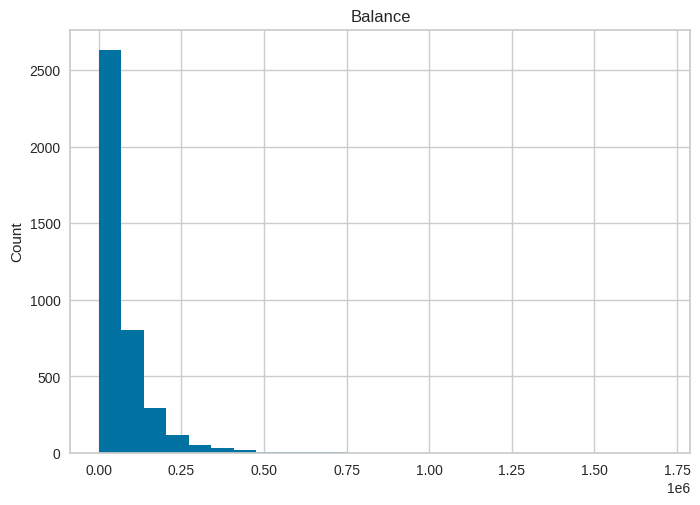

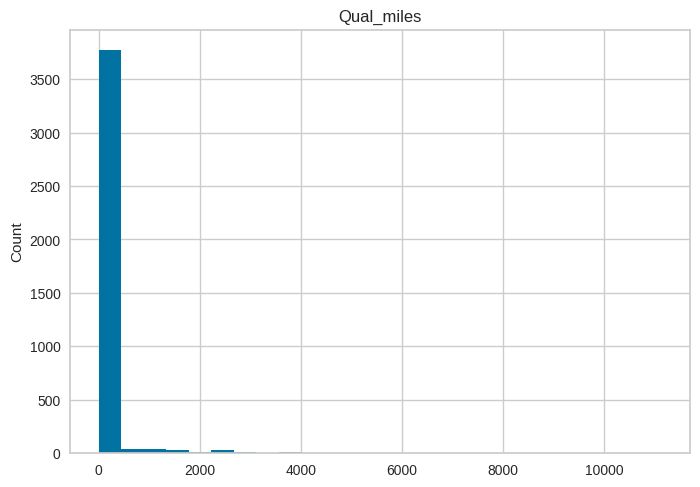

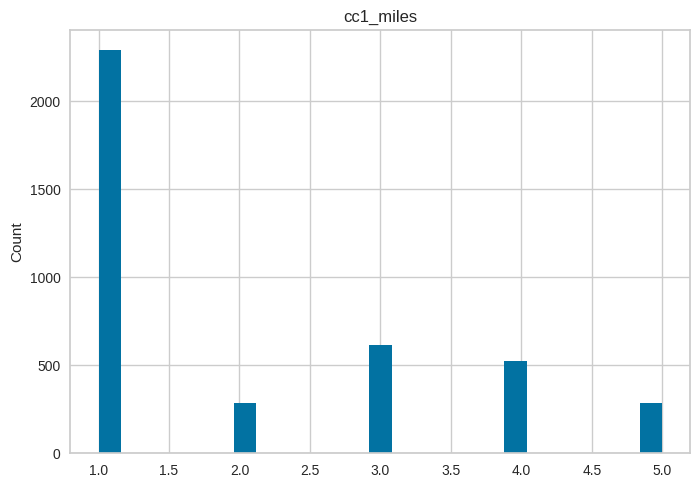

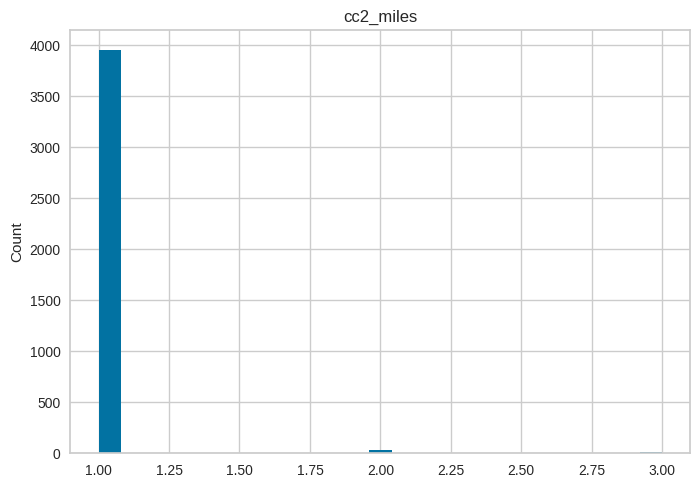

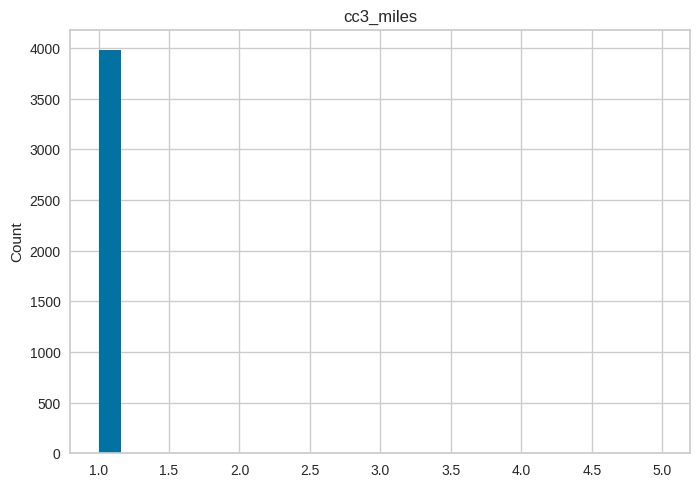

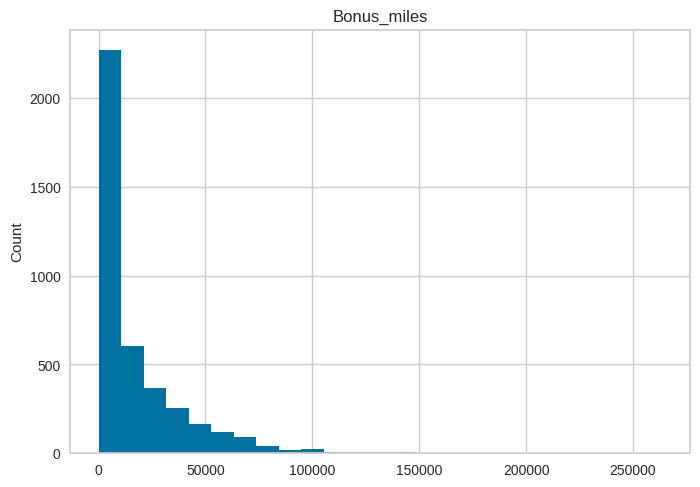

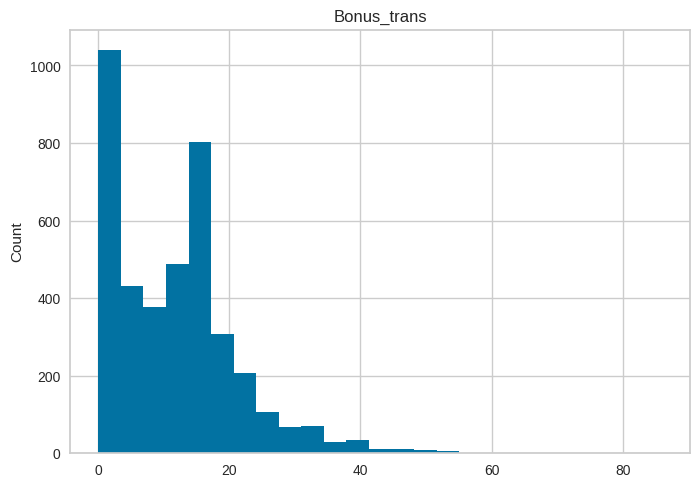

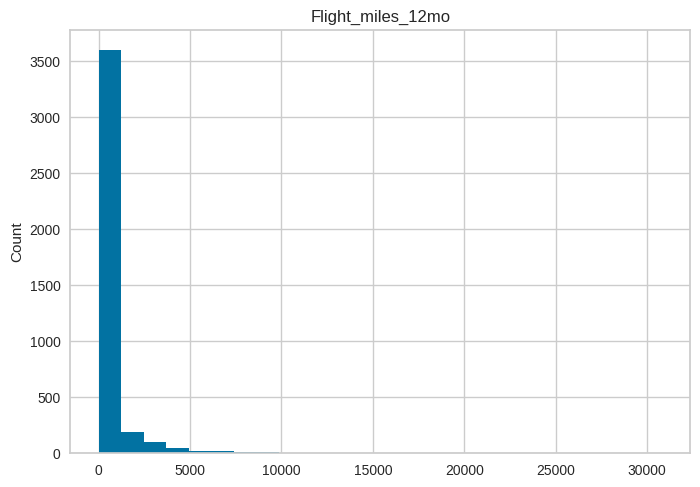

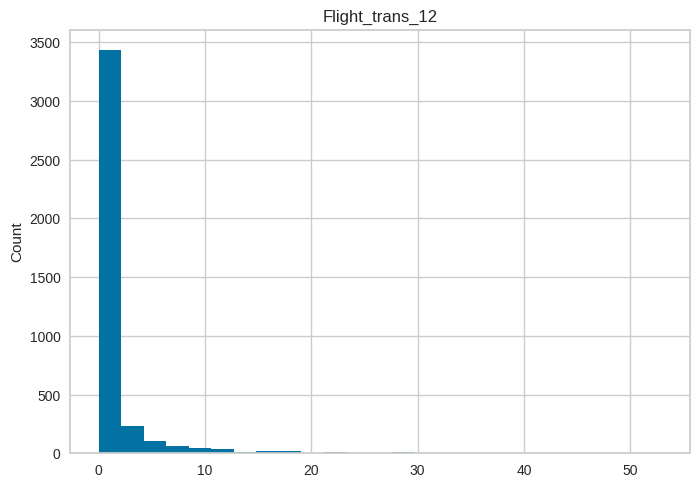

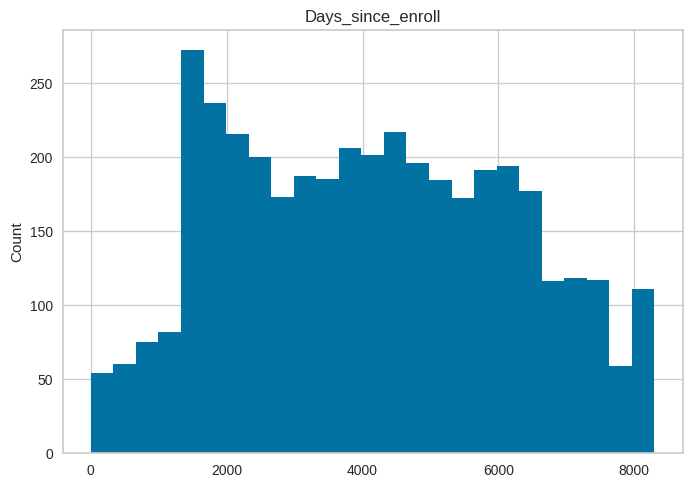

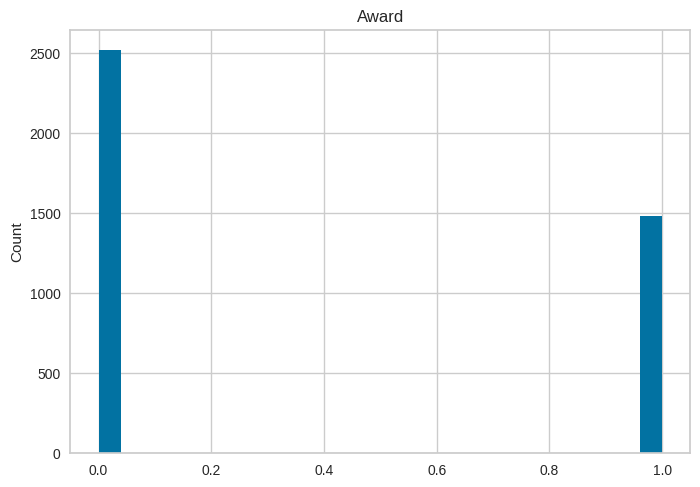

In [14]:
for feature in data.columns:
    data = data.copy()
    data[feature].hist(bins=25)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

Balance


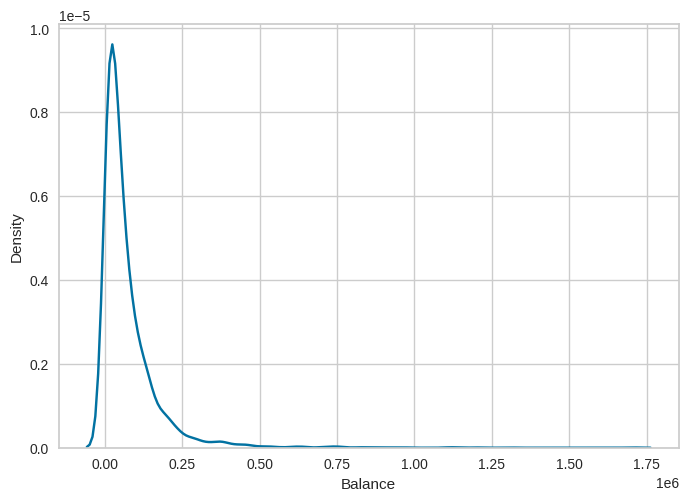

Qual_miles


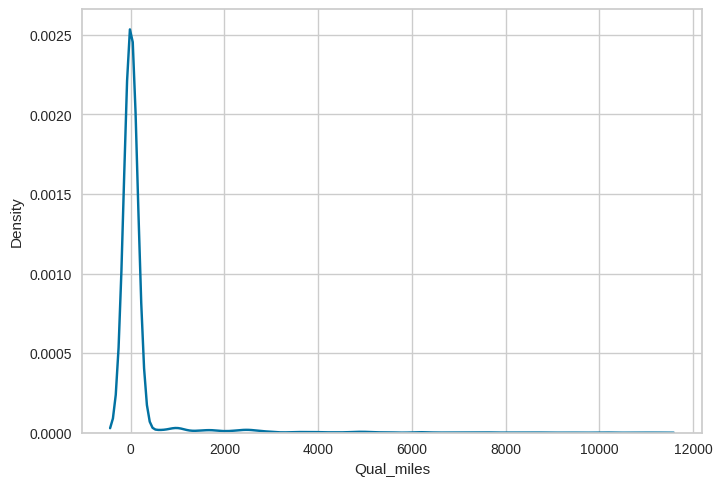

cc1_miles


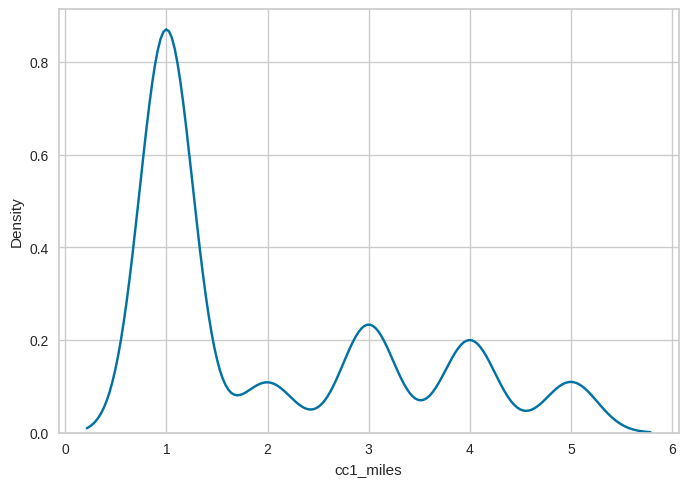

cc2_miles


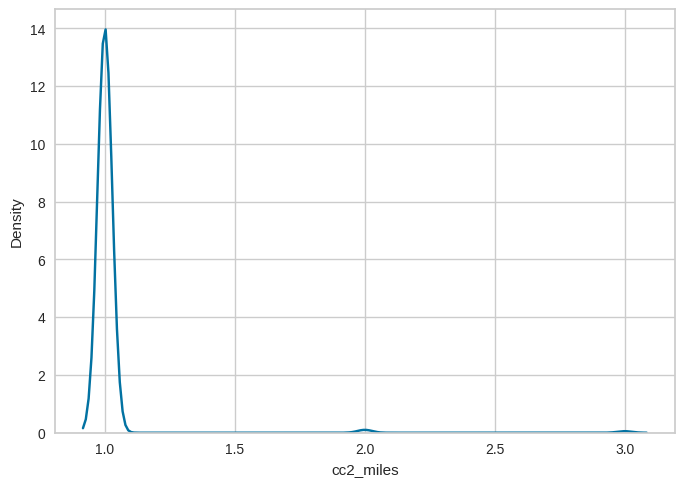

cc3_miles


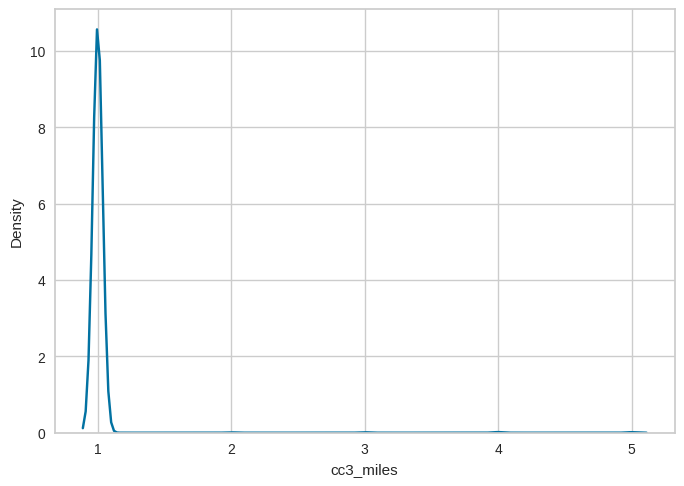

Bonus_miles


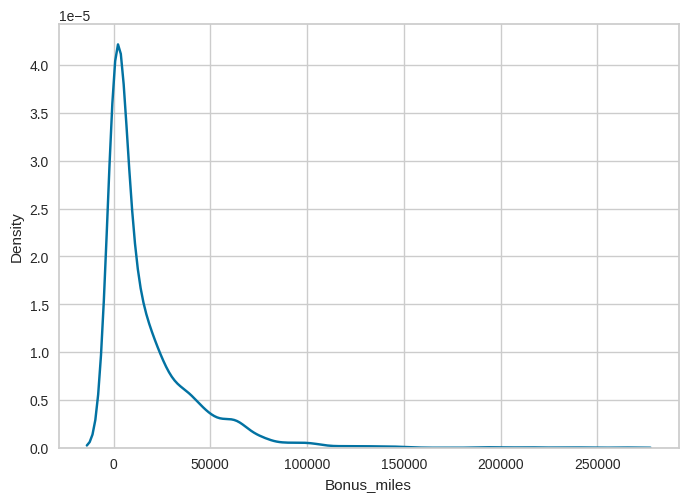

Bonus_trans


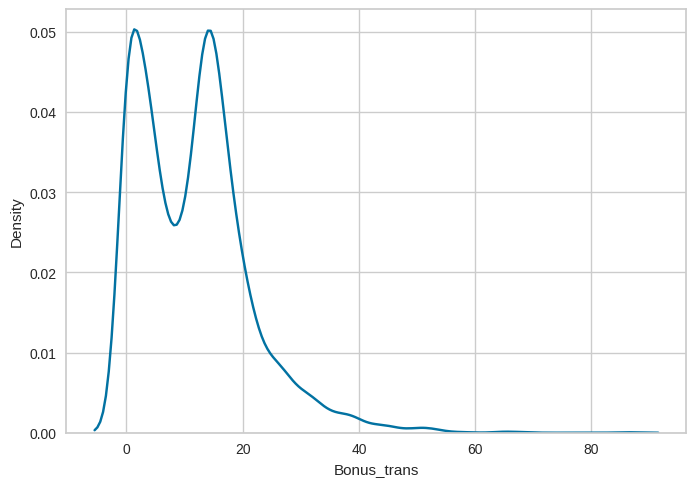

Flight_miles_12mo


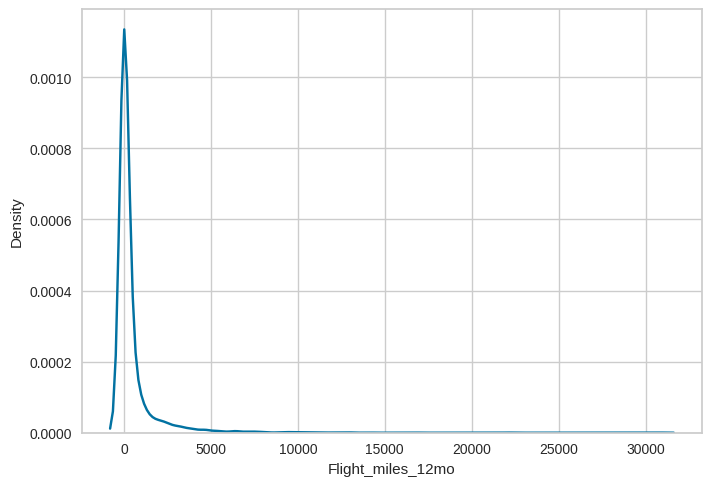

Flight_trans_12


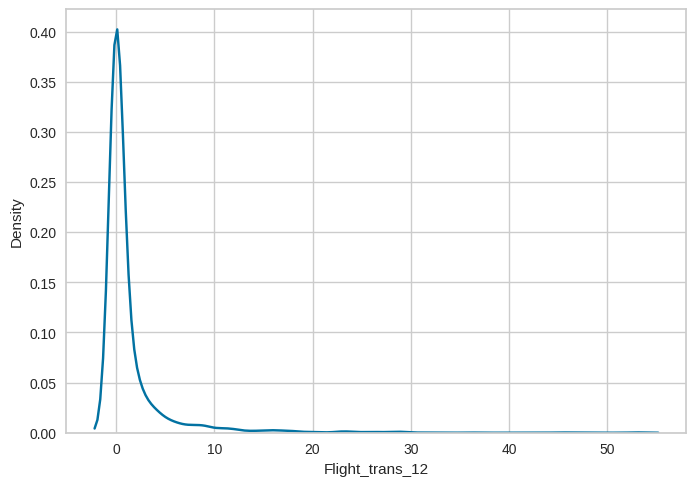

Days_since_enroll


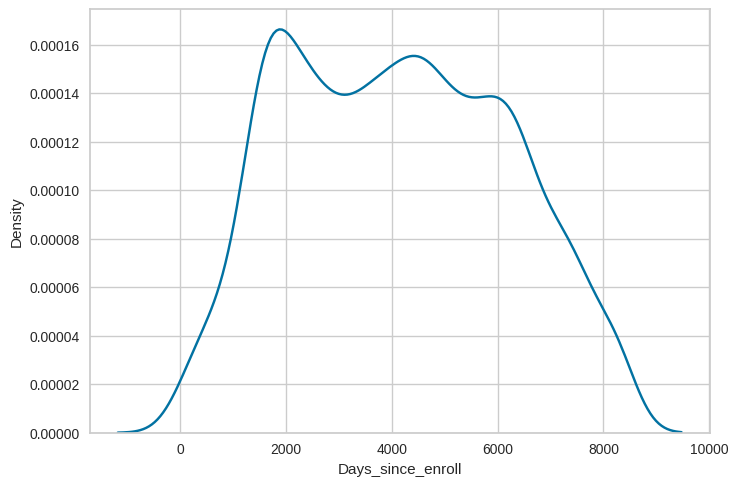

Award


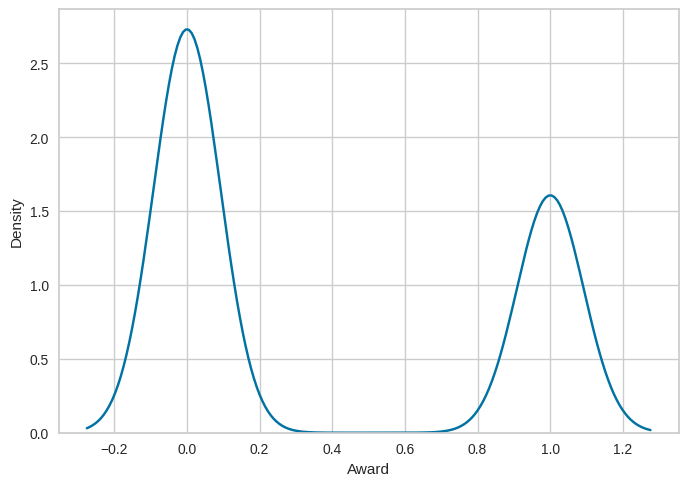

In [15]:
# Kernel Density for every feature, singled out

for n in data.columns:
    print(n)
    sns.kdeplot(data[n])
    plt.show()

# 3.1 Outliers Detection

In [16]:
data.columns

Index(['Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles',
       'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12',
       'Days_since_enroll', 'Award'],
      dtype='object')

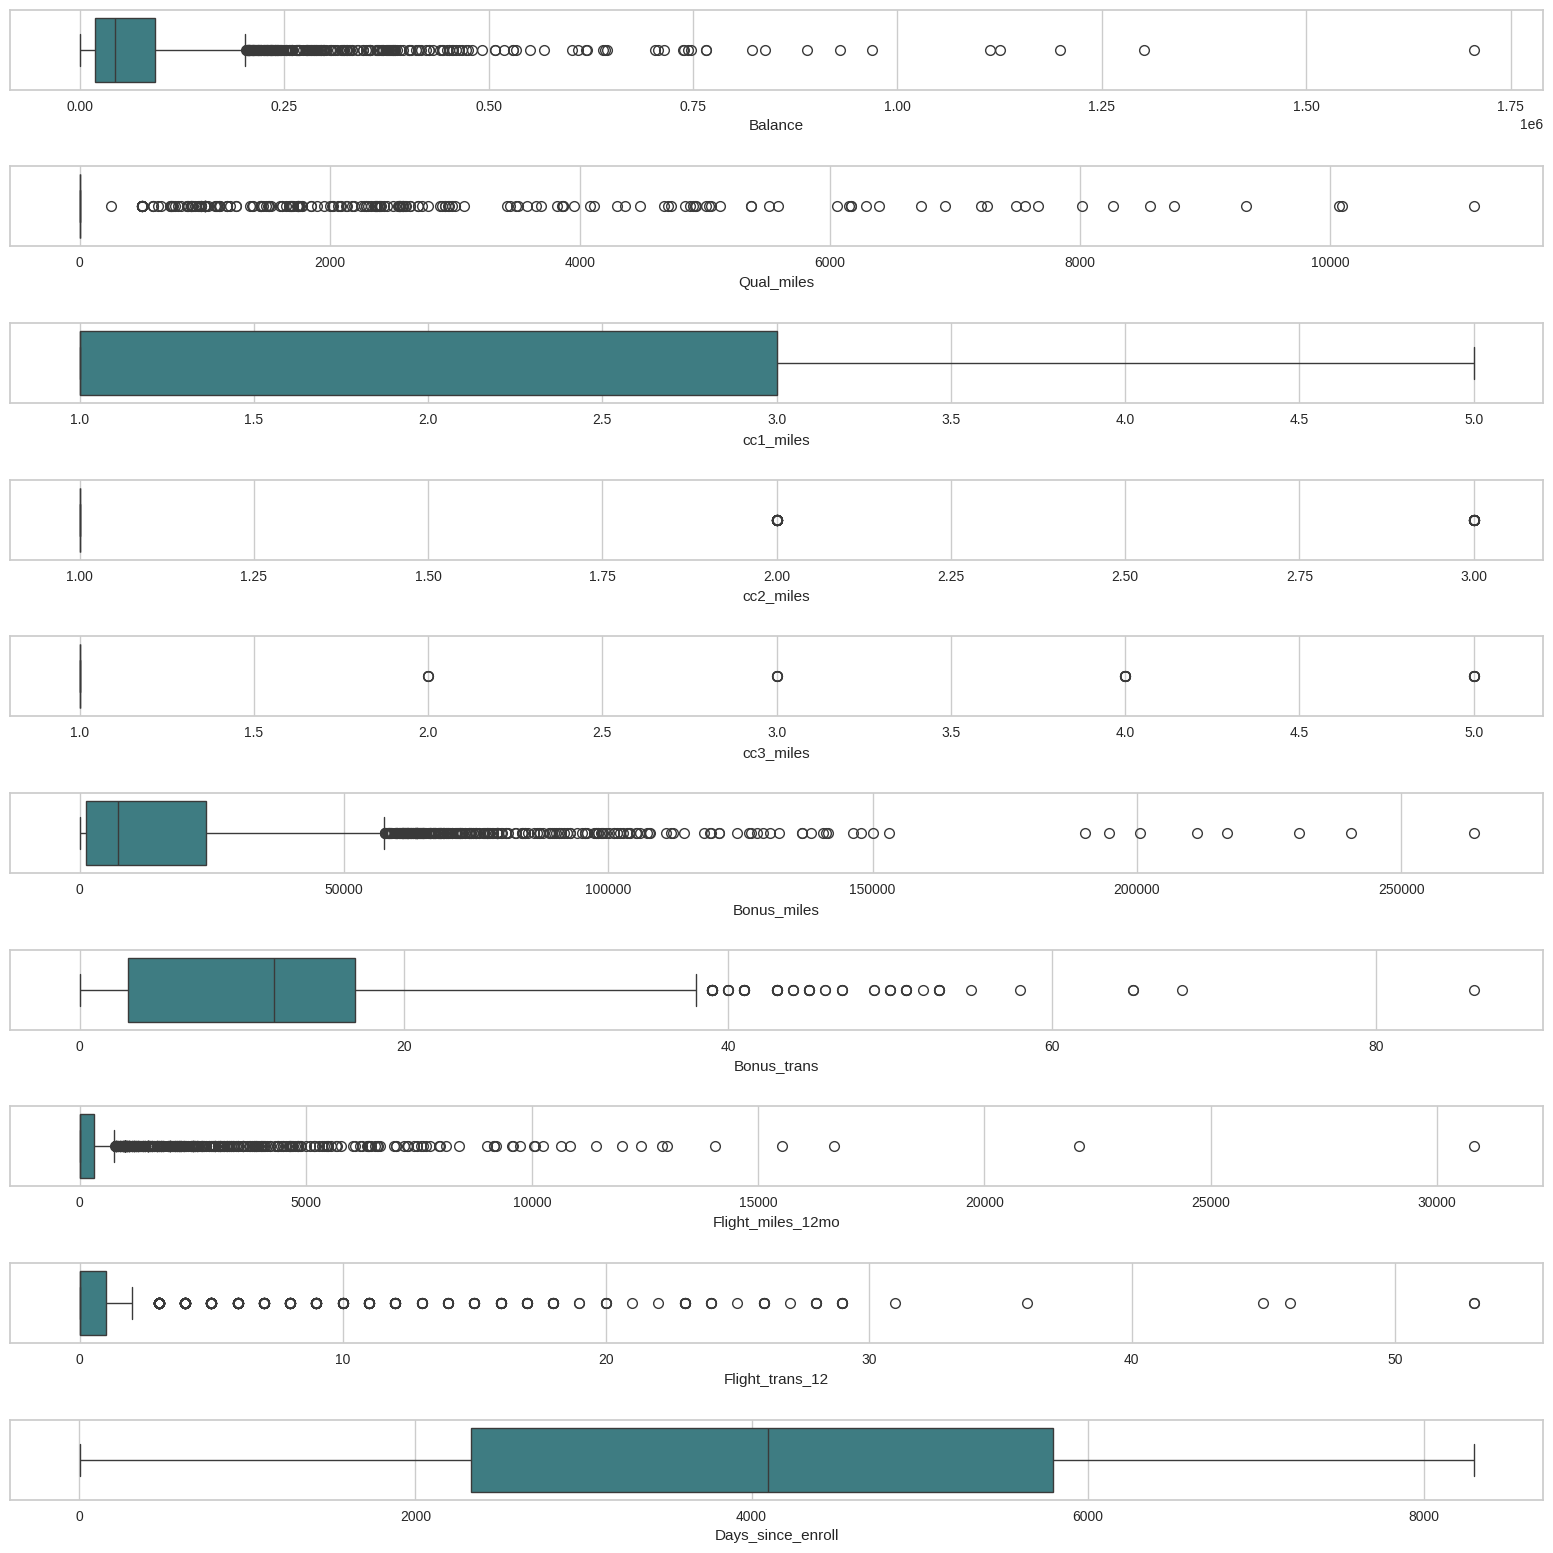

In [17]:
ot=data.copy()
fig, axes  = plt.subplots(10,1, figsize = (16,16), sharex=False, sharey=False)
sns.boxplot(x='Balance',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='Qual_miles',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='cc1_miles',data=ot,palette='crest',ax=axes[2])
sns.boxplot(x='cc2_miles',data=ot,palette='crest',ax=axes[3])
sns.boxplot(x='cc3_miles',data=ot,palette='crest',ax=axes[4])
sns.boxplot(x='Bonus_miles',data=ot,palette='crest',ax=axes[5])
sns.boxplot(x='Bonus_trans',data=ot,palette='crest',ax=axes[6])
sns.boxplot(x='Flight_miles_12mo',data=ot,palette='crest',ax=axes[7])
sns.boxplot(x='Flight_trans_12',data=ot,palette='crest',ax=axes[8])
sns.boxplot(x='Days_since_enroll',data=ot,palette='crest',ax=axes[9])
plt.tight_layout(pad=2.0)

<Axes: >

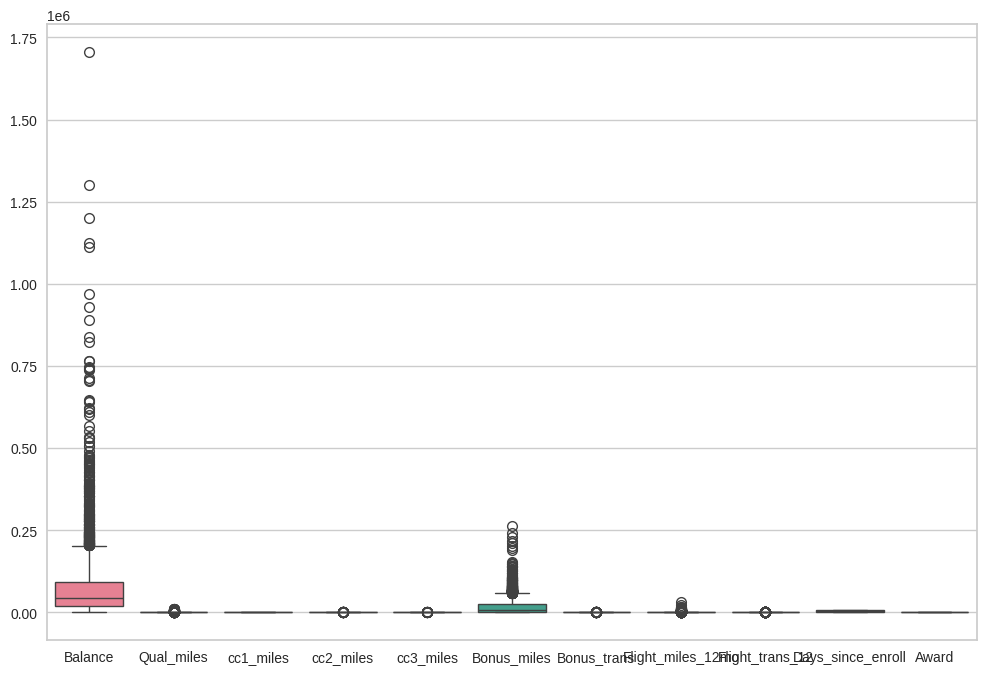

In [18]:
# Box plot for every feature in the same graph

plt.figure(figsize=(12,8))
sns.boxplot(data=data)

<Axes: >

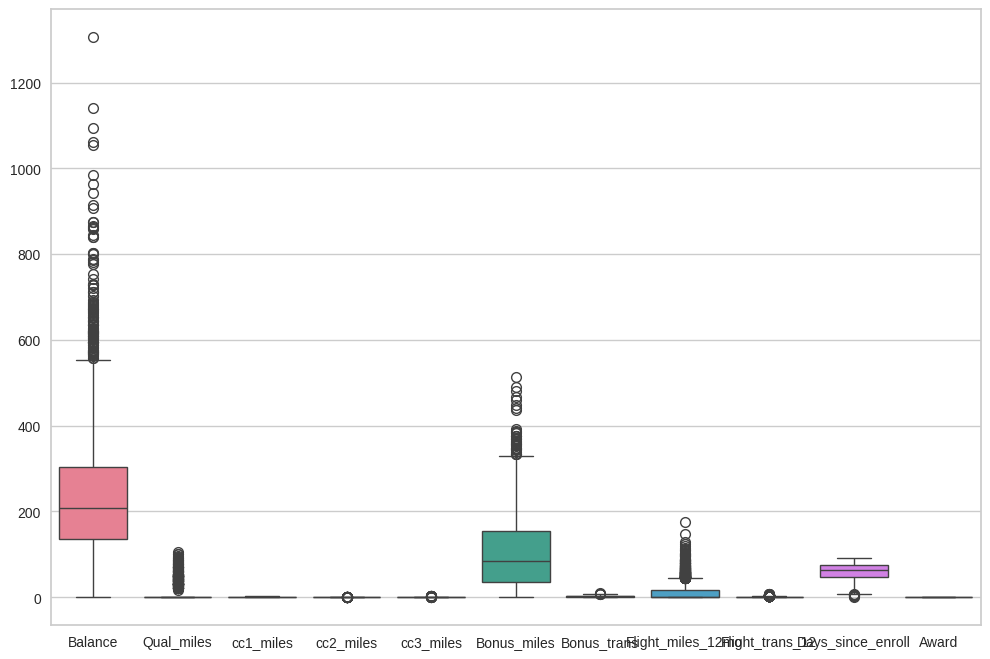

In [19]:
# We use sqrt () to see more clearly despite the outliers

plt.figure(figsize=(12,8))
sns.boxplot(data=np.sqrt(data))

# 4. Data Visualization

In [20]:
countNotermdeposit = len(data[data.Award == 0])
counthavetermdeposit = len(data[data.Award == 1])

In [21]:
print("Percentage of Customer doesn't have an Award: {:.2f}%".format((countNotermdeposit / (len(data.Award))*100)))
print("Percentage of Customer does have an Award: {:.2f}%".format((counthavetermdeposit / (len(data.Award))*100)))

Percentage of Customer doesn't have an Award: 62.96%
Percentage of Customer does have an Award: 37.04%


Text(0.5, 1.0, 'Whether the client has a Award or not')

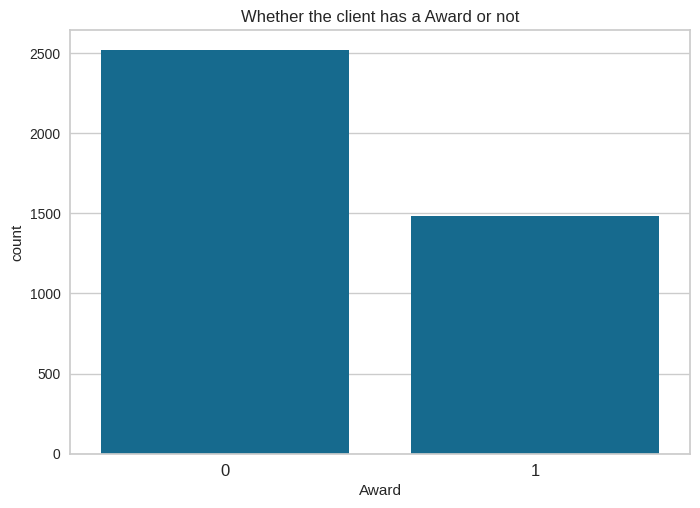

In [22]:
sns.countplot(x = 'Award', data=data,
               order = data['Award'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Whether the client has a Award or not')

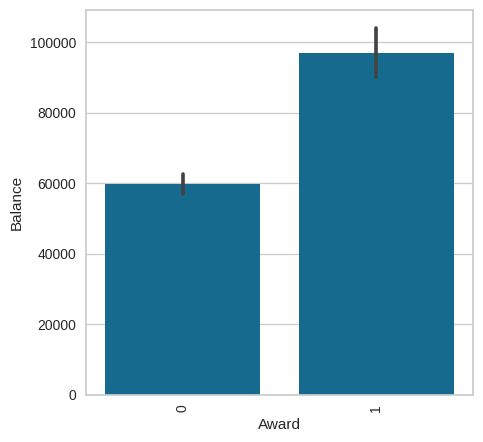

In [23]:
# Balance : Nimber of miles eligible for award travel

plt.figure(figsize = (5,5))
Balance = data[['Award', 'Balance']].sort_values("Balance", ascending = False)
ax = sns.barplot(x='Award', y ='Balance', data= Balance)
ax.set(xlabel = 'Award', ylabel = 'Balance')
plt.xticks(rotation = 90)
plt.show()

In [24]:
# What is correlated with Balance?

corr_matrix = data.corr()
corr_matrix["Balance"].sort_values(ascending=False)

Balance              1.000000
Bonus_miles          0.403410
cc1_miles            0.338252
Bonus_trans          0.324797
Days_since_enroll    0.262975
Flight_trans_12      0.255656
Flight_miles_12mo    0.217509
Award                0.178380
Qual_miles           0.108696
cc3_miles            0.035234
cc2_miles           -0.008822
Name: Balance, dtype: float64

In [25]:
dataset = pd.read_excel("EastWestAirlines.xlsx", sheet_name = 'data')
sns.pairplot(dataset)

Output hidden; open in https://colab.research.google.com to view.

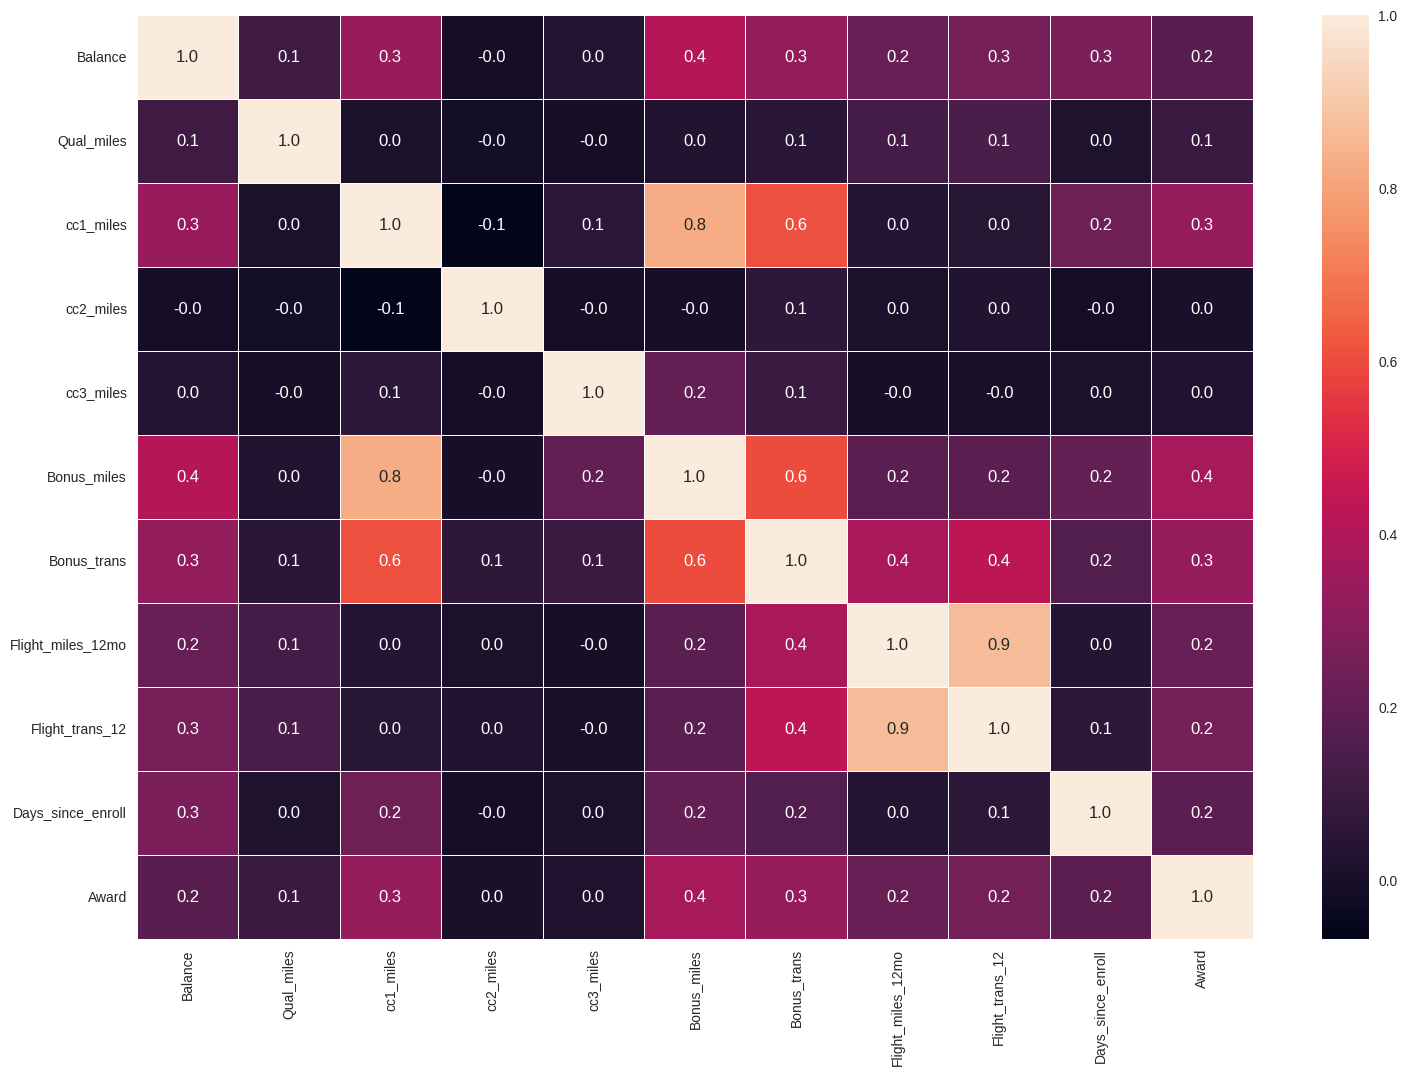

In [26]:
 # Correlation heatmap

 f, ax = plt.subplots(figsize = (18,12))
 sns.heatmap(data.corr(), annot= True, linewidths = .5, fmt = '.1f', ax=ax)
 plt.show()

Unique points in this correlatno matrix:

   + flight_trans_12 is positively with flight_miles_12mo
   + bonus_trans is positively correlated with cc1_miles
   + bonus_trans is positively correlated with bonus_miles
   + bonus_trans is positively correlated with cc1_miles

In other words, the following are positively correlated

   + Number of flight transactions in the past 12 months <-> Number of flight miles in the past 12 months

   + Miles passengers earn with the freq. flyer credit card <-> Amount of non-flight transactions

   + Number of non-flight bonus transactions <-> Miles passengers earn from non-flight bonus transaction

   + Miles passengers earn from non-flight bonus transaction <-> Miles passengers earn with the freq.  flyer credit card

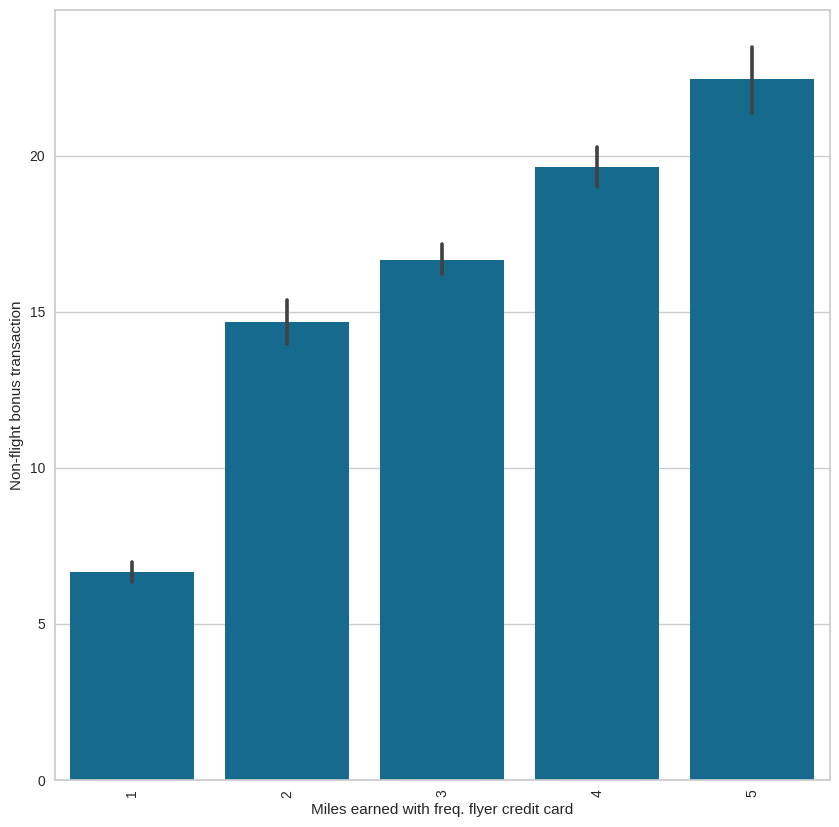

In [27]:
# Plotting frequent flying bonuses vs. non-fligh bonus transactions

plt.figure(figsize = (10,10))
sorted_data = data[['cc1_miles', 'Bonus_trans']].sort_values('Bonus_trans', ascending = False)
ax = sns.barplot(x='cc1_miles', y='Bonus_trans', data = sorted_data)
ax.set(xlabel = 'Miles earned with freq. flyer credit card', ylabel = 'Non-flight bonus transaction')
plt.xticks(rotation = 90)
plt.show()

People who fly more frequently use bonus transactions more

# 5. Data Preprocessing

5.1) Standardizing the data

In [28]:
standard_scaler = StandardScaler()
std_df = standard_scaler.fit_transform(data)
std_df.shape

(3998, 11)

# 5.2) Normalizing the data

In [29]:
# Using MinMaxScaler for accuracy result comparision

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

minmax_df = minmax.fit_transform(data)
minmax_df.shape

(3998, 11)

# 6. K-Means Clustering

After all the analyses we now start with the K-Means Clustering procedure

K-Means is a centroid-based algorithm, or a distance based algorithm, where we calculate the distance to assign a point to a cluster.  In K-Means, each cluster is associated with a centroid.

The main objective of the K-Means algorithm is to minimize the sum of distances between the points and their respective cluster centroid.  The first step in k-means is to pick the number of cluster, k.  Then keep the iterations running untill one of the below satisifes:

   1.  Centroids of newly formed clusters do not change
   2.  Points remain in the same cluster
   3.  Maximum number of iteration are reached

In K-Means clustering we need to first assign the K Number of clusters which can be taken up using the thumb rule of 'Sqrt(n) / 2'  or plotting the Elbow curve, aka Scree plot.   

6.1  Elbow Method for Determining Cluster Amount

# Standard Scaler Applied on Data

In [30]:
cluster_range = range(1, 15)
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters, n_init = 10)
    clusters.fit(std_df)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)
clusters_df = pd.DataFrame({"num_clusters":cluster_range, 'cluster_errors':cluster_errors})
clusters_df

,num_clusters,cluster_errors
0,1,43978.000000
1,2,35402.348376
2,3,30894.288718
3,4,27157.030546
4,5,24536.670969
5,6,21086.484132
6,7,19163.139552
7,8,17315.658819
8,9,15958.297469
9,10,14725.185611


In [31]:
# within-cluster sum of squares criterion
# Use Elbow Graph to find optimum number of clusters (K value) from k values range
# The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion WCSS
# Ramdom state can be anything from 0 to 42, but the same number to be used everything, so that the results don't change.

wcss=[]
for i in range(1,9):
    kmeans = KMeans(n_clusters = i, random_state = 2)
    kmeans.fit(std_df)
    wcss.append(kmeans.inertia_)

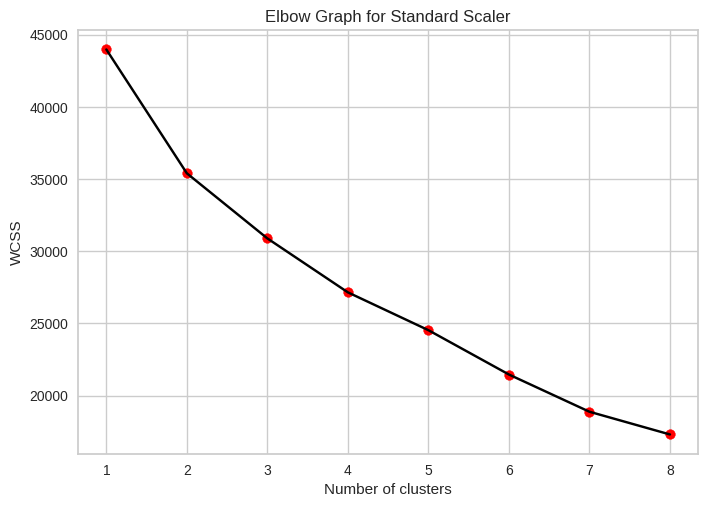

In [32]:
# Plot K values range vs WCSS to get Elbow graph for choosing K (no.of clusters)
plt.plot(range(1,9), wcss, color= 'black')
plt.scatter(range(1,9),wcss,color='red')
plt.title("Elbow Graph for Standard Scaler")
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# There is no clear "elbow" visible. A choice of 3 or 4 clusters seems to be fair.  Let's see the silhouette score

Internal measures for cluster validation

   + The goal of partitioning clustering algorithms is to split the data set into clusters of objects, such that:

The objects in the same cluster are similar as much as possible, and the objects in different clusters are highly distinct.  That is, we want the average distance within cluster to be as small as possible: and the average distance between clusters to be as large as possible.

Internal validation measures reflect often the compactness, the connectedness and the separation of the cluster partitions.
  + **Compactness or cluster cohesion:** Measures how close are the objects within the same cluster. A lower within cluster variation is an indicator of a good compactness (i.e., a good clustering).  The different indices for eveluating the compactness of clusters are base on distance meansures such as the cluster-wise within average/median distances between observations.

  + **Separation:** Measures how well-separated a cluster is from other clusters.  The indices used as separation measure include: distances between cluster centers the pairwise minimum distances between objects in different clusters.

  + **Connectivity:**  Corresponds to what extent items are placed in the same cluster as their nearest neighbors in the data space.  The connectivity has a value between 0 and infinity and should be minimized.  Generally most of the indices used for internal clusterin validataion combine compactness and separation measures as follow:

Index = (α×Separation)(β×Compactness)

Where α and β are weights.

In this section, we'll describe the two commonly used indices for assessing the goodness of clustering: the silhouette width and the Dunn index.  These internal measure can be used also to determine the optimal number of clusters in the data.
      

# 6.2 Silhouette Score

Silhouette coefficient

  + The silhouette analysis measures how well an observation is clustered and it estimates the average distance between clusters.  The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters.

For each observation i, the silhouette width  si is calculated as follows:

For each observation i, calculate the average dissimilarity ai betweeen i and all other points of the cluster to which i belongs.

For all other clusters C, to which i does not belong, calculate the average dissimilarity d(i, C) of i to all observations of C.  The smallest of therse d(i,C) is defined as bi=minCd(i, C). The value of bi can be seen as the dissimilarity between i and its "neighbor" cluster, i.e. the nearest one to which it does not belong.

   
   + Finally the silhouette width of the observation i is defined by the formula:
     SI = (bi-ai)/max(ai,bi).
     Silhouette width can be interpreted as follow:

Observations with a large SI (almost 1) are very well clustered.

A small Si (around 0 ) means that the observation lies between two clusters.

Observations with a negative Si are probably placed in the wrong cluster.

In [33]:
from sklearn.metrics import silhouette_score
n_clusters = [2,3,4,5,6,7,8,9,10]
clusters_inertia = []
s_scores =[]

for n in n_clusters:
    KM_est = KMeans(n_clusters = n, init = 'k-means++').fit(std_df)
    clusters_inertia.append(KM_est.inertia_)
    silhouette_avg = silhouette_score(std_df, KM_est.labels_)
    s_scores.append(silhouette_avg)

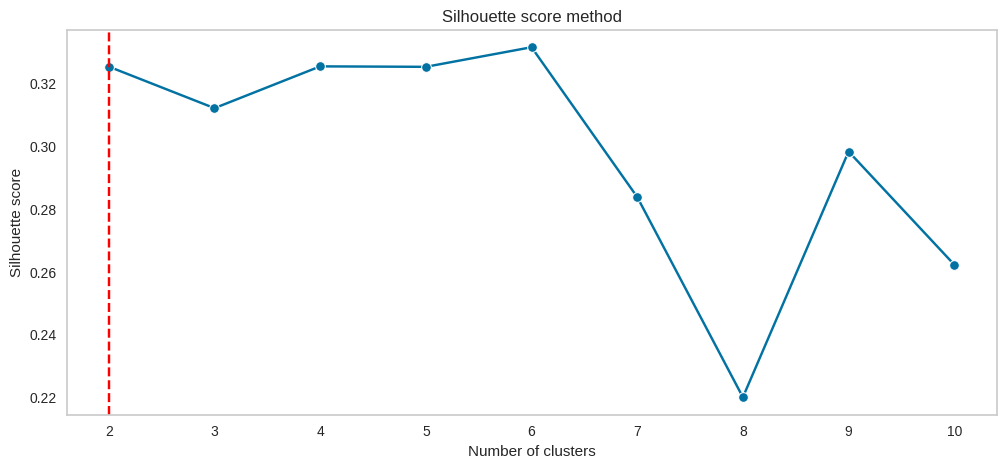

In [34]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(x=n_clusters, y=s_scores, marker='o', ax=ax)
ax.set_title('Silhouette score method')
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(2, ls='--', c='red')
plt.grid()
plt.show()

# Silhouette score method indicates the best options would be respectively 2 clusters.

Elbow Plot for Standard Scaler data


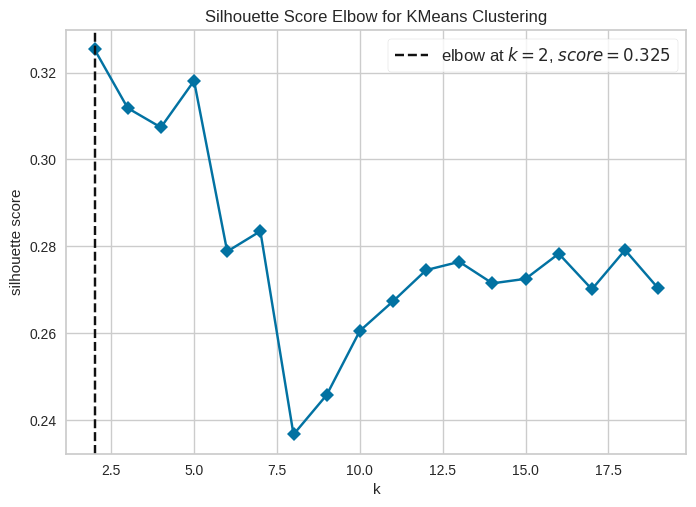

In [35]:
model = KMeans(random_state = 10, max_iter= 500, init = 'k-means++')

# Instantiate the KElbowVisualizer with the number of clusters and the metric
visualizer = KElbowVisualizer(model, k=(2,20), metric='silhouette', timings=False)

# Fit the data and visualize
print('Elbow Plot for Standard Scaler data')
visualizer.fit(std_df)
visualizer.poof()
plt.show()

In [36]:
# With the elbow method, the ideal number of clusters to use was 6.
# We will also use the Silhouette score to determine an optimal number.

clust_list = [2,3,4,5,6,7,8,9,]

# Silhouette score for stadardScaler applied on data.

for n_clusters in clust_list:
    clusterer1 = KMeans(n_clusters= n_clusters, random_state = 0)
    cluster_labels1 = clusterer1.fit_predict(std_df)
    sil_score1 = sil(std_df, cluster_labels1)
    print("For n_clusters =", n_clusters, "The average silhouette_score is:", sil_score1)


For n_clusters = 2 The average silhouette_score is: 0.32531882107641713
For n_clusters = 3 The average silhouette_score is: 0.3120743629337082
For n_clusters = 4 The average silhouette_score is: 0.31003837126661404
For n_clusters = 5 The average silhouette_score is: 0.32371282485521125
For n_clusters = 6 The average silhouette_score is: 0.33378006995858245
For n_clusters = 7 The average silhouette_score is: 0.22365222966492318
For n_clusters = 8 The average silhouette_score is: 0.237314726017899
For n_clusters = 9 The average silhouette_score is: 0.24489425763143474


In [37]:
range_n_clusters = [2,3,4,5,6,7,8,9]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig,(ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(118,7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1,1]
    ax1.set_xlim([-0.1,1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # Plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(std_df) + (n_clusters +1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(std_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into to density and separation of the formed clusters
    silhouette_avg = sil(std_df, cluster_labels)
    print("For n_clusters =", n_clusters,
          'The average silhouette_score is:', silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(std_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various cluusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color = 'red', linestyle ='--')

    ax1.set_yticks([])
    ax1.set_xticks([-0.1,0,0.2,0.4,0.6,0.8,1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(std_df[:,6], std_df[:,9], marker = '.', s=30,lw=0, alpha= 0.7,
                c=colors, edgecolor='k')

    # Labeling the cluters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:,6], centers[:,9], marker = 'o',
                c='White', alpha= 1, s=200, edgecolor ='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[6], c[9], marker = '$%d$'  % i, alpha = 1,
                    s=50, edgecolor = 'k')
    ax2.set_title('The visualization of the clustered data after Standard scaler.')
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('Feature space for the 2nd feature')

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data"
                   "with n_clusters = %d" % n_clusters),
                 fontsize=40, fontweight='bold')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Conclusion:**

According to the silhouette score of :    

The standardized data, the ideal number of clusters is 6, with a score higher than other options, of 0.33


# 6.3 Build KMeans Cluster alforithm using K=6 and Standard Scaler Applier Dataset

In [38]:
# We have found good number of cluster = 6
# model building using cluster number = 6

model_kmeans = KMeans(n_clusters = 6, random_state = 0 , init = 'k-means++')
y_predict_kmeans = model_kmeans.fit_predict(std_df)
y_predict_kmeans.shape

(3998,)

In [39]:
y_predict_kmeans

array([2, 2, 2, ..., 1, 2, 2], dtype=int32)

In [40]:
model_kmeans.labels_

array([2, 2, 2, ..., 1, 2, 2], dtype=int32)

In [41]:
model_kmeans.cluster_centers_

array([[ 1.13661978,  0.41416471,  0.13434996, -0.09825429, -0.06277446,
         0.6561826 ,  1.70528239,  3.77057434,  4.00160023,  0.27124922,
         0.88372079],
       [ 0.43360655, -0.11304557,  1.20989562, -0.09825429, -0.05450669,
         0.92790005,  0.75243243, -0.08073137, -0.0896464 ,  0.37051107,
         0.57831847],
       [-0.2944391 , -0.12884258, -0.6016064 , -0.09825429, -0.06072325,
        -0.51689575, -0.49353627, -0.18636708, -0.19846289, -0.19781849,
        -0.34994003],
       [-0.04706705, -0.15626333, -0.66838569,  9.03710982, -0.06277446,
        -0.1018366 ,  0.61758448,  0.08745745,  0.22023229, -0.0727739 ,
         0.0515894 ],
       [ 0.63950059, -0.08446932,  1.02183982, -0.09825429, 15.64433492,
         3.1793166 ,  1.7144102 ,  0.0332068 ,  0.05959833,  0.2395819 ,
         0.33731815],
       [ 0.45689596,  6.73023291, -0.0434189 , -0.09825429, -0.06277446,
         0.06353524,  0.06505958,  0.3595715 ,  0.39411338, -0.07153328,
         0.387

In [42]:
model_kmeans.inertia_

21086.325857898286

In [43]:
df = pd.read_excel('EastWestAirlines.xlsx', sheet_name='data')
df.rename({'ID#':'ID', 'Award?':'Award'}, inplace=True, axis=1)
df = df.iloc[:len(model_kmeans.labels_)]
df['Kmeans_label'] = model_kmeans.labels_[:len(df)]

In [44]:
df.groupby('Kmeans_label').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Kmeans_label,,,,,,,,,,,,
0,1743.832168,186693.804196,448.678322,2.223776,1.000000,1.000000,32356.041958,27.440559,5535.755245,16.209790,4679.286713,0.797203
1,1599.815768,116810.773130,58.236525,3.690265,1.000000,1.001609,39058.715205,18.599356,350.356396,1.041030,4887.473049,0.645213
2,2233.154432,44217.498997,45.776976,1.246691,1.000401,1.000401,4900.360209,6.998396,210.077016,0.638588,3707.307661,0.203369
3,2269.348837,68823.976744,23.255814,1.139535,2.325581,1.000000,14588.395349,17.325581,582.627907,2.209302,3968.953488,0.395349
4,1664.866667,138061.400000,78.800000,3.466667,1.000000,4.066667,93927.866667,28.066667,506.666667,1.600000,4613.866667,0.533333
5,2057.278689,117559.196721,5302.639344,1.983607,1.000000,1.000000,18566.000000,12.131148,922.655738,2.786885,3971.524590,0.540984


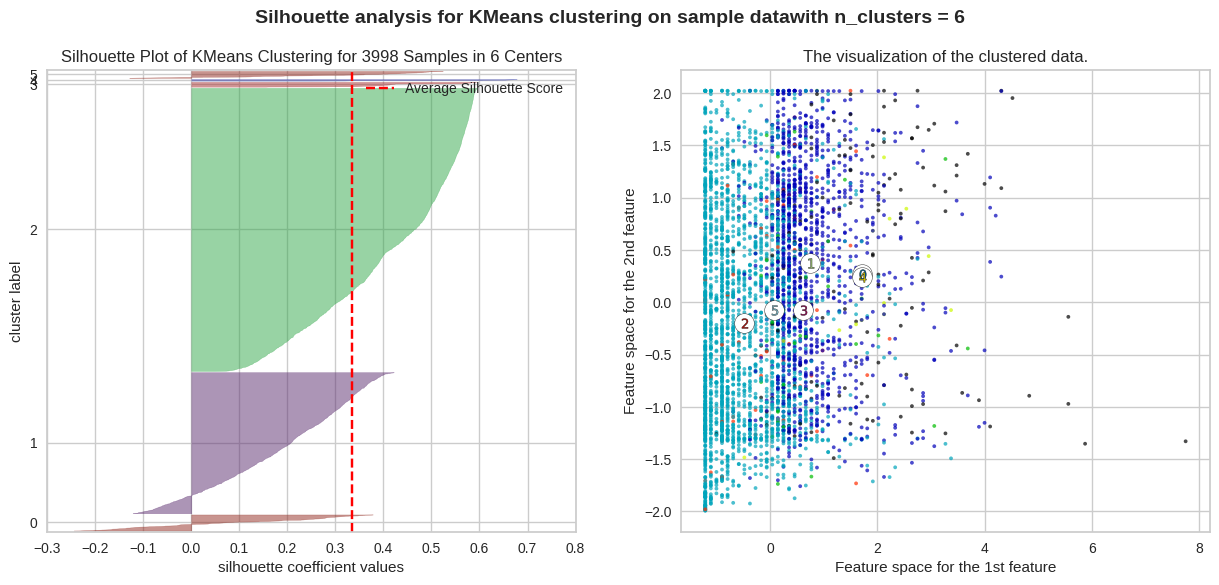

In [45]:
from yellowbrick.cluster import SilhouetteVisualizer

fig,(ax1, ax2)= plt.subplots(1,2,sharey=False)
fig.set_size_inches(15,6)

sil_visualizer1= SilhouetteVisualizer(model_kmeans, ax = ax1, colors=['#922B21', '#5B2C6F', '#32a84a', '#a83232', '#323aa8'])
sil_visualizer1.fit(std_df)
# 2 nd Plot showing the actual clusters formed

colors1 = cm.nipy_spectral(model_kmeans.labels_.astype(float) / 6)
ax2.scatter(std_df[:,6], std_df[:,9], marker = '.', s=30, lw=0, alpha = 0.7,
            c=colors1, edgecolor = 'k')

# Labeling the clusters
centers1 =model_kmeans.cluster_centers_

# Draw white circles at cluster centers
ax2.scatter(centers1[:, 6], centers1[:, 9], marker='o', c='white', alpha=1, s=200, edgecolor= 'k')
for i, c in enumerate(centers1):
    ax2.scatter(c[6], c[9], marker = '$%d$' % i, alpha=1, s=50, edgecolor = 'k')

ax2.set_title(label = 'The visualization of the clustered data.')
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(('Silhouette analysis for KMeans clustering on sample data'
               "with n_clusters = %d" % 6), fontsize =14, fontweight = 'bold')
sil_visualizer1.show()
plt.show()

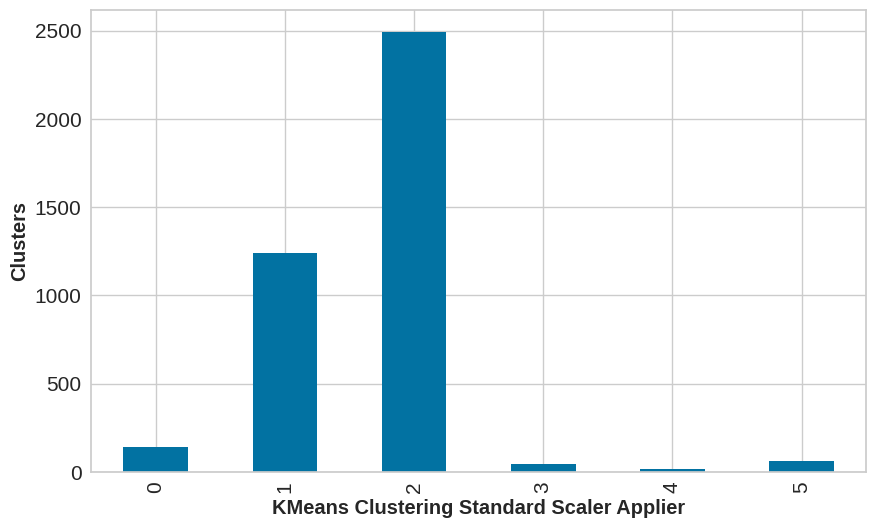

In [46]:
# Plotting barplot using groupby method to get visualize how many no. in each cluster

fig, ax = plt.subplots(figsize=(10,6))
df.groupby(['Kmeans_label']).count()['ID'].plot(kind='bar')
plt.ylabel('ID Counts')
ax.set_xlabel("KMeans Clustering Standard Scaler Applier", fontsize = 'large', fontweight='bold' )
ax.set_ylabel('Clusters', fontsize='large', fontweight = 'bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

# 6.4 Elbow Method and Silhouette Score on MinMaxScaler Applied Data

In [47]:
cluster_errors.append(clusters.inertia_)

In [48]:
cluster_range = range(1,15)
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters, n_init =10)
    clusters.fit(minmax_df)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)
cluster_df = pd.DataFrame({'num_clusters':cluster_range, "cluster_errors":cluster_errors})
cluster_df

,num_clusters,cluster_errors
0,1,1830.468023
1,2,823.558363
2,3,625.101720
3,4,436.642089
4,5,348.934750
5,6,315.354184
6,7,287.720047
7,8,263.204647
8,9,245.237337
9,10,226.103101


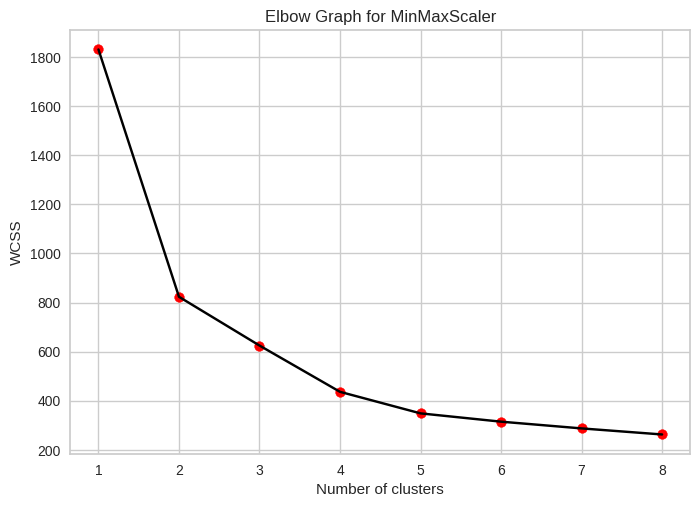

In [49]:
wcss=[]
for i in range(1,9):
    kmeans=KMeans(n_clusters=i, random_state=2)
    kmeans.fit(minmax_df)
    wcss.append(kmeans.inertia_)

# plot K values range vs WCSS to get Elbow graph for choosing K (no.of clusteres)
plt.plot(range(1,9), wcss,color = 'black')
plt.scatter(range(1,9), wcss, color='red')
plt.title('Elbow Graph for MinMaxScaler')
plt.xlabel("Number of clusters")
plt.ylabel('WCSS')
plt.show()

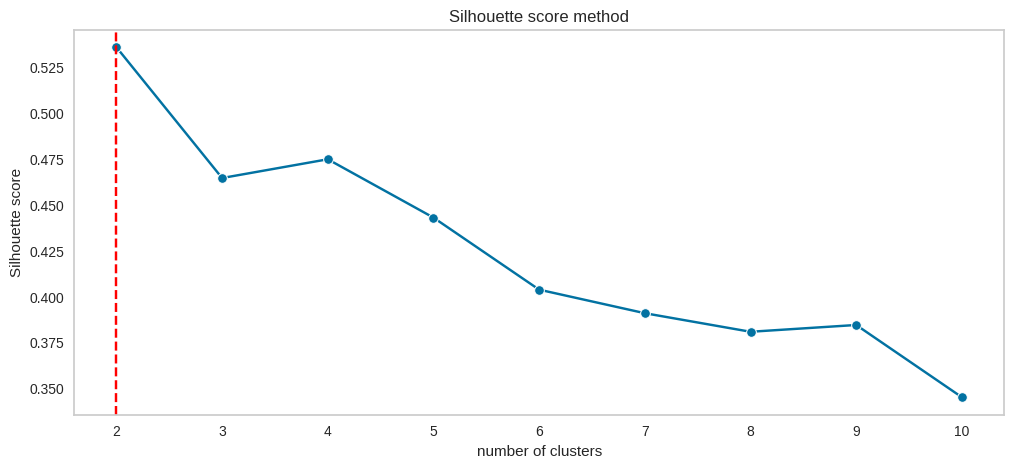

In [50]:
from sklearn.metrics import silhouette_score
n_clusters = [2,3,4,5,6,7,8,9,10]
clusters_inertia = []
s_scores = []

for n in n_clusters:
    KM_est = KMeans(n_clusters = n, init ='k-means++').fit(minmax_df)
    clusters_inertia.append(KM_est.inertia_)
    silhouette_avg = silhouette_score(minmax_df, KM_est.labels_)
    s_scores.append(silhouette_avg)

fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(x=n_clusters, y=s_scores, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(2, ls='--', c='red')
plt.grid()
plt.show()

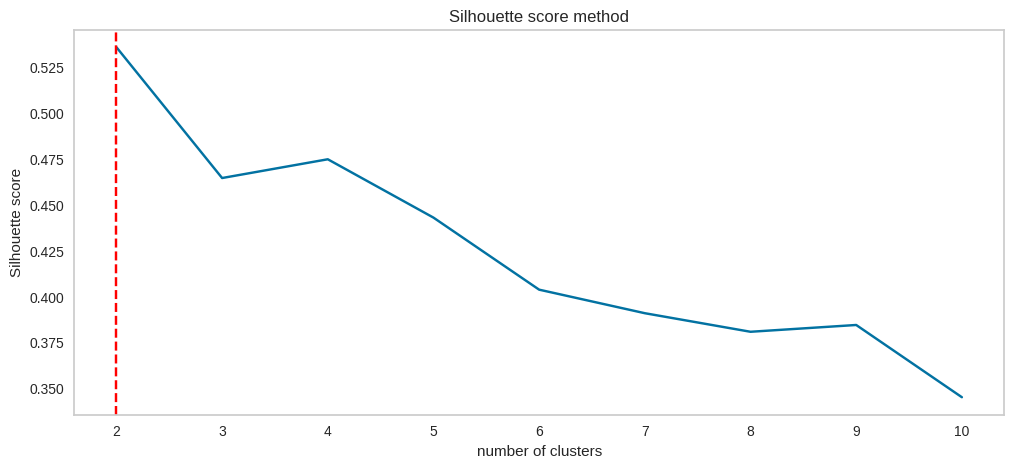

In [51]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(x=n_clusters, y=s_scores)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(2, ls='--', c='red')
plt.grid()
plt.show()

In [52]:
# With the elbow method, the ideal number of clusters to use was 6.
# We will also use the Silhouette score to determine an optimal number.

clust_list = [2,3,4,5,6,7,8,9]

# Silhouette score for MinMaxScaler Applied on data.

for n_clusters in clust_list:
    clusterer1 = KMeans(n_clusters = n_clusters, random_state=0)
    cluster_labels1 = clusterer1.fit_predict(minmax_df)
    sil_score1 = sil(minmax_df, cluster_labels1)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", sil_score1)

For n_clusters = 2 The average silhouette_score is : 0.535888544052936
For n_clusters = 3 The average silhouette_score is : 0.46479982811211207
For n_clusters = 4 The average silhouette_score is : 0.47479527849897574
For n_clusters = 5 The average silhouette_score is : 0.4429787795230887
For n_clusters = 6 The average silhouette_score is : 0.4036935704266899
For n_clusters = 7 The average silhouette_score is : 0.3902543534131159
For n_clusters = 8 The average silhouette_score is : 0.3800928436109383
For n_clusters = 9 The average silhouette_score is : 0.38422218036747746


In [53]:
range_n_clusters = [2,3,4,5,6,7,8,9]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(minmax_df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(minmax_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = sil(minmax_df, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(minmax_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(minmax_df[:,6], minmax_df[:,9], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:,6], centers[:,9], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[6], c[9], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data after Standard scaler.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

Conclusion:

According to the silhouette score of:

   + The MinMax Scaler Applied data, the ideal number of clusters is 2, with a score higher than other options, of 0.53, but if you notice the number of cluster 5 has also the best variation within cluster and between cluster with zero to no values going towards -1 and no mismatch in cluster segregation than the consecutive rest.

   + If we check silhouette score with Normalize data kmeans model 0.53 > 0.32.  Best score always close to +1.

# 6.5  Build KMeans Cluster algorithm using K=2 and MinMaxScaler Applied Dataset

In [54]:
# We have found good number of cluster = 2
# Moodel building using cluster number = 2

model_kmeans = KMeans(n_clusters=2, random_state=0, init='k-means++')
y_predict_kmans = model_kmeans.fit_predict(minmax_df)
y_predict_kmeans.shape

(3998,)

In [55]:
y_predict_kmeans

array([2, 2, 2, ..., 1, 2, 2], dtype=int32)

In [56]:
model_kmeans.labels_

array([1, 1, 1, ..., 0, 1, 1], dtype=int32)

In [57]:
model_kmeans.cluster_centers_

array([[ 5.69280197e-02,  2.15461508e-02,  4.15428764e-01,
         7.76502363e-03,  4.55773126e-03,  1.09621005e-01,
         1.83518364e-01,  2.78255837e-02,  4.90489598e-02,
         5.57398375e-01,  1.00000000e+00],
       [ 3.50949497e-02,  7.86125463e-03,  1.76400477e-01,
         6.95272149e-03,  2.18514104e-03,  3.88029372e-02,
         1.06355850e-01,  7.34601684e-03,  1.23162495e-02,
         4.60517912e-01, -6.99440506e-15]])

In [58]:
model_kmeans.inertia_

823.5583625482047

In [59]:
df = pd.read_excel("EastWestAirlines.xlsx", sheet_name='data')
df.rename({'ID#':'ID', 'Award?':'Award'}, inplace=True, axis=1)
df = df.iloc[:-1,:]
df['Kmeans_label'] = model_kmeans.labels_

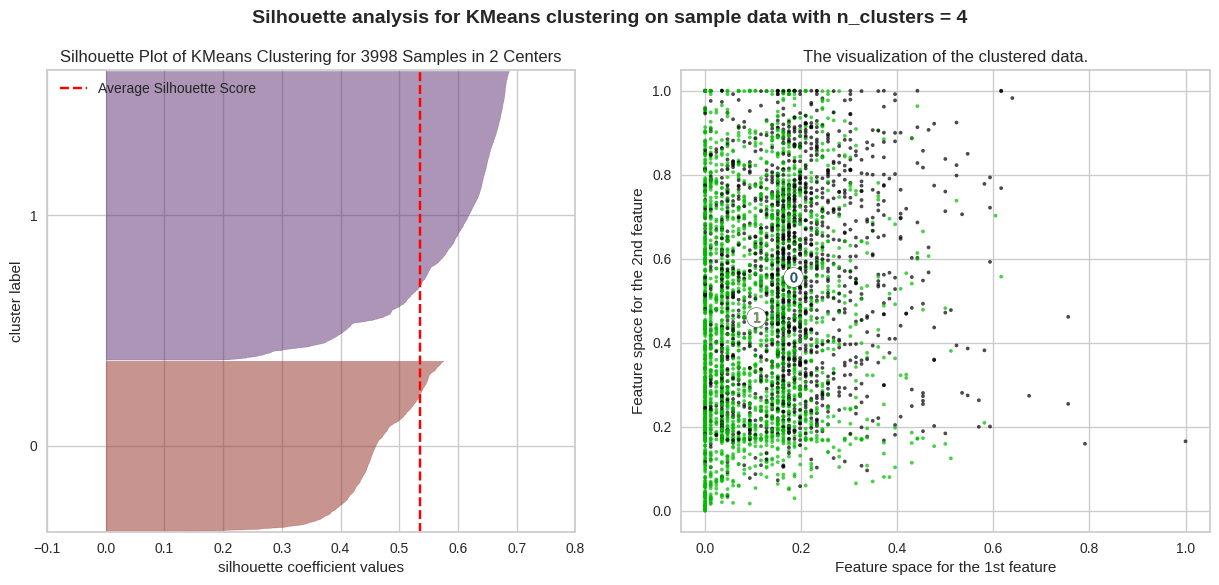

In [60]:
from yellowbrick.cluster import SilhouetteVisualizer

fig,(ax1,ax2) = plt.subplots(1,2,sharey=False)
fig.set_size_inches(15,6)



sil_visualizer1 = SilhouetteVisualizer(model_kmeans,ax= ax1, colors=['#922B21','#5B2C6F','#1B4F72','#32a84a'])
sil_visualizer1.fit(minmax_df)


# 2nd Plot showing the actual clusters formed

import matplotlib.cm as cm
colors1 = cm.nipy_spectral(model_kmeans.labels_.astype(float) / 2) # 2 is number of clusters
ax2.scatter(minmax_df[:, 6], minmax_df[:, 9], marker='.', s=30, lw=0, alpha=0.7,
                c=colors1, edgecolor='k')

# Labeling the clusters
centers1 = model_kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers1[:, 6], centers1[:, 9], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers1):
    ax2.scatter(c[6], c[9], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')


ax2.set_title(label ="The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % 4),fontsize=14, fontweight='bold')

sil_visualizer1.show()
plt.show()

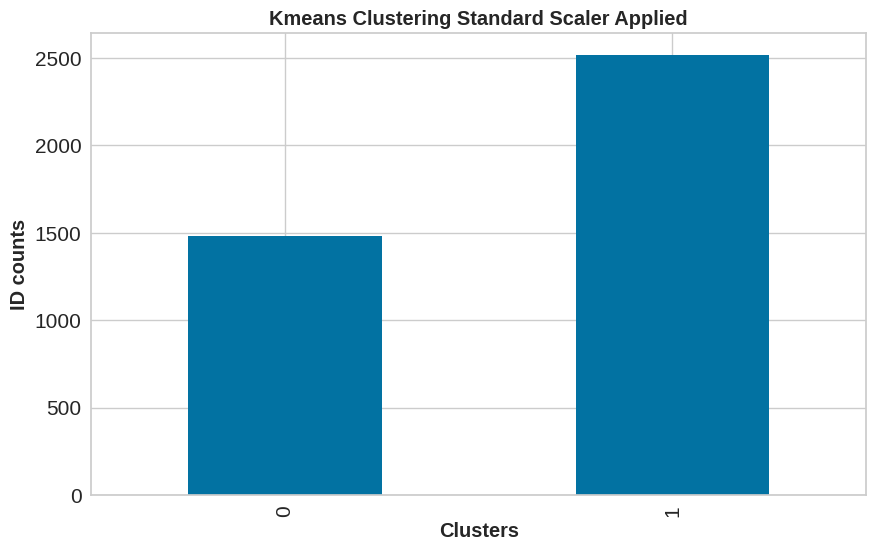

In [61]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['Kmeans_label']).count()['ID'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('Kmeans Clustering Standard Scaler Applied',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='large', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='large', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

In [62]:
# Group data by Clusters (K=2)
df.groupby('Kmeans_label').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Kmeans_label,,,,,,,,,,,,
0,1745.571911,96831.899392,237.526671,2.648211,1.015530,1.018231,28640.350439,15.695476,854.774477,2.593518,4624.956786,0.983795
1,2172.447358,59960.528407,89.208184,1.713548,1.013905,1.008741,10387.715932,9.197855,227.986492,0.656337,3821.676599,0.009535


We can now clearly see the 2 number of clusters formed, which can be described as under

  + Cluster 1, Tier 1 = '1' = Defines the group of fliers that earn the most out of the card are frequent fliers

  + cluster 0, Tier2 = '0' = Defines the group of fliers that eran the least and are the least frequent fliers

# 7. Hierarchical Clustering Algorithm

### What is Hierarchical Clustering?
+ Hierarchical clustering is a type of unsupervised machine learning algorithm used to cluster unlabeled data points. Like K-means clustering, hierarchical clustering also groups together the data points with similar characteristics.One of the major considerations in using the K-means algorithm is deciding the value of K beforehand. The hierarchical clustering algorithm does not have this restriction.The output of the hierarchical clustering algorithm is quite different from the K-mean algorithm as well. It results in an inverted tree-shaped structure, called the dendrogram.

#### Types Of Hierarchical Clustering:
##### There are two types of hierarchical clustering:

+ <b>Agglomerative</b>: The data points are clustered using a bottom-up approach starting with individual data points.
+ <b>Divisive</b>: The top-down approach is followed where all the data points are treated as one big cluster and the clustering process involves dividing the one big cluster into several small clusters.

#### The key operation in hierarchical agglomerative clustering is to repeatedly combine the two nearest clusters into a larger cluster. There are three key questions that need to be answered first:

How many numbers of cluster. Also deciding which transformation data we will use to build model.

Qiuck Notes:

linkage{“ward”, “complete”, “average”, “single”}, default=”ward” Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.

ward minimizes the variance of the clusters being merged.

average uses the average of the distances of each observation of the two sets.

complete or maximum linkage uses the maximum distances between all observations of the two sets.

single uses the minimum of the distances between all observations of the two sets.

 # 7.1 Dendrogram on MinMaxScaler Applier on Dataset

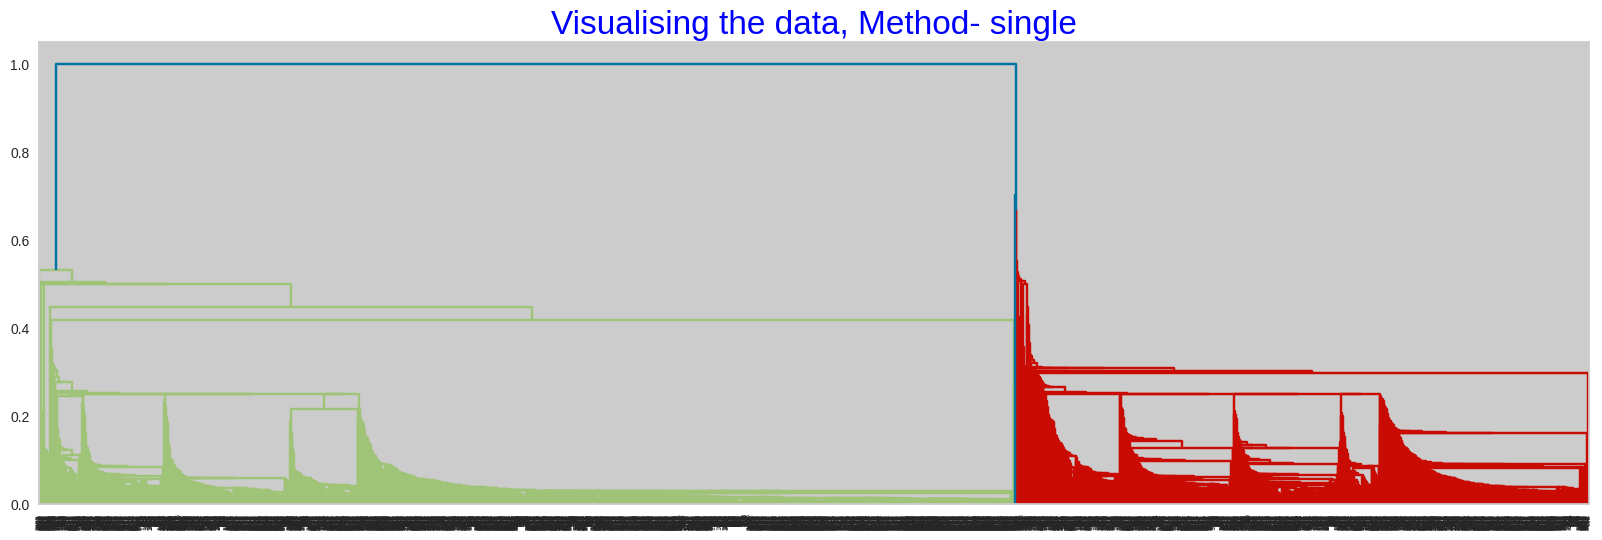

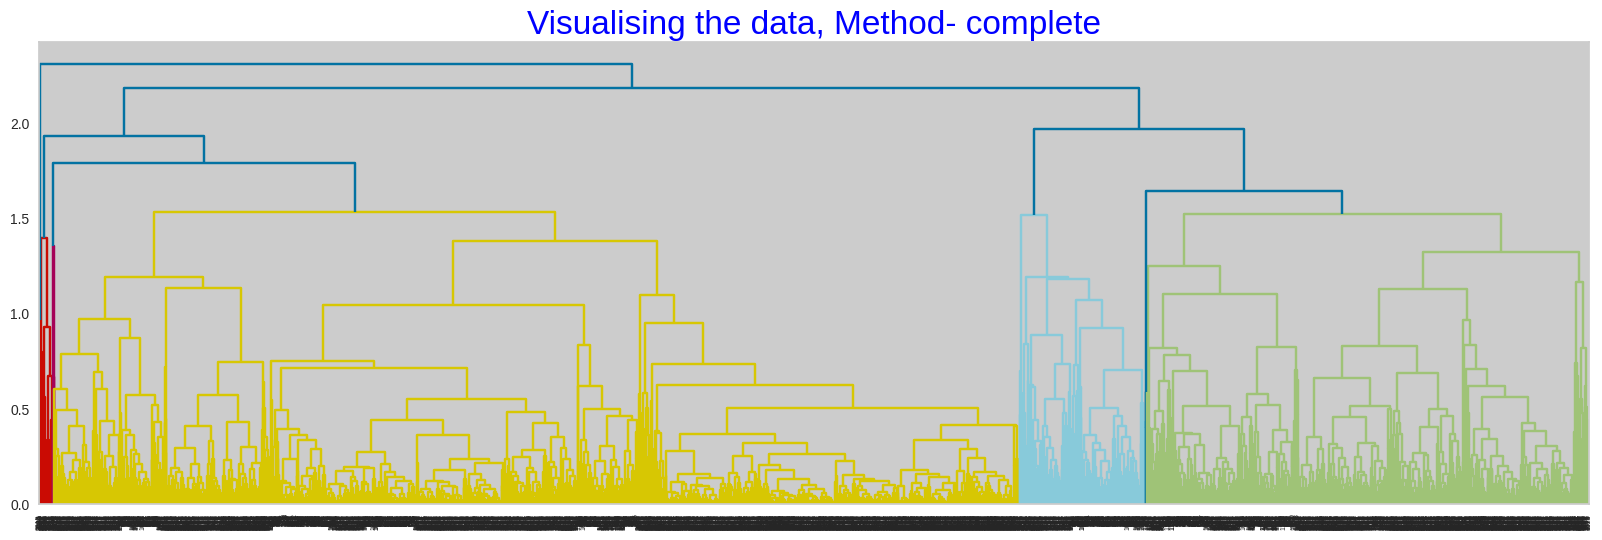

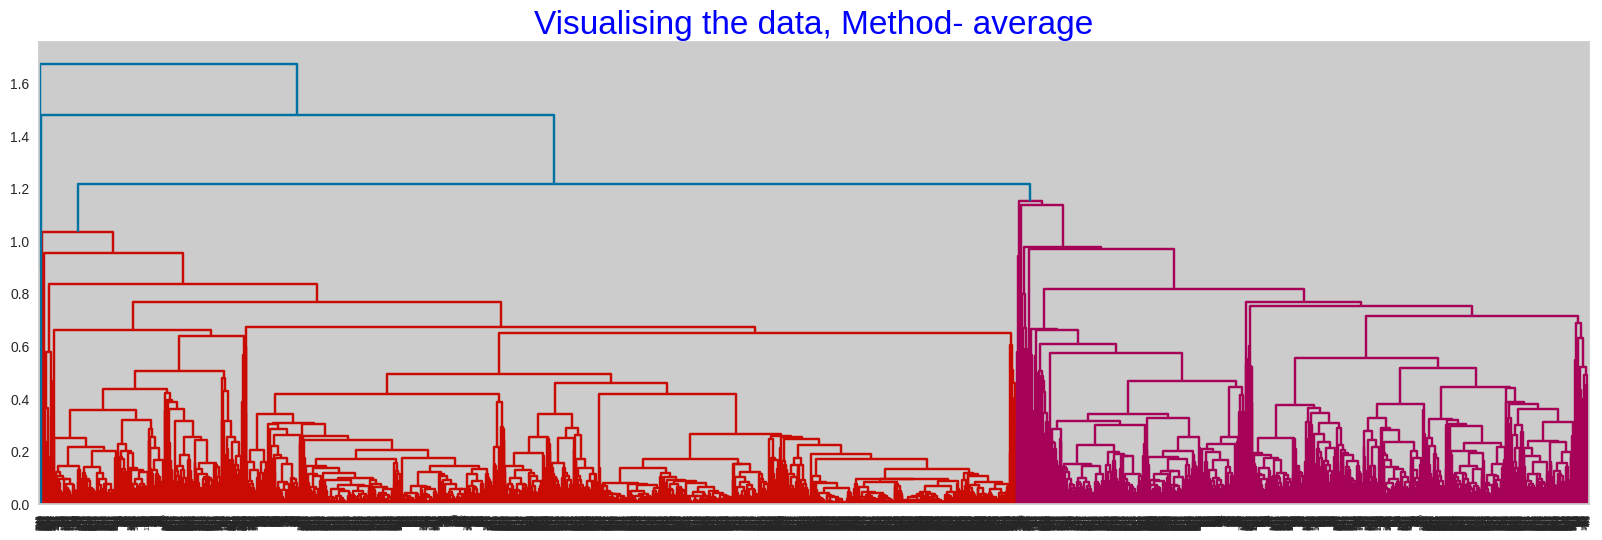

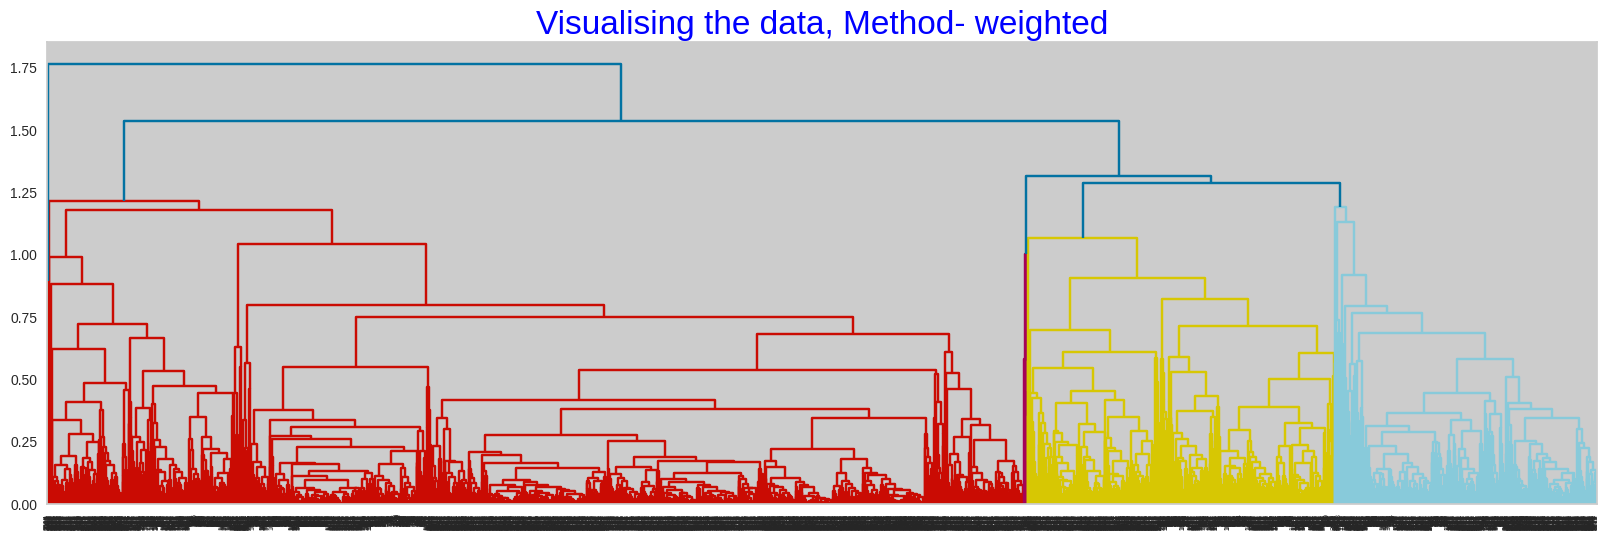

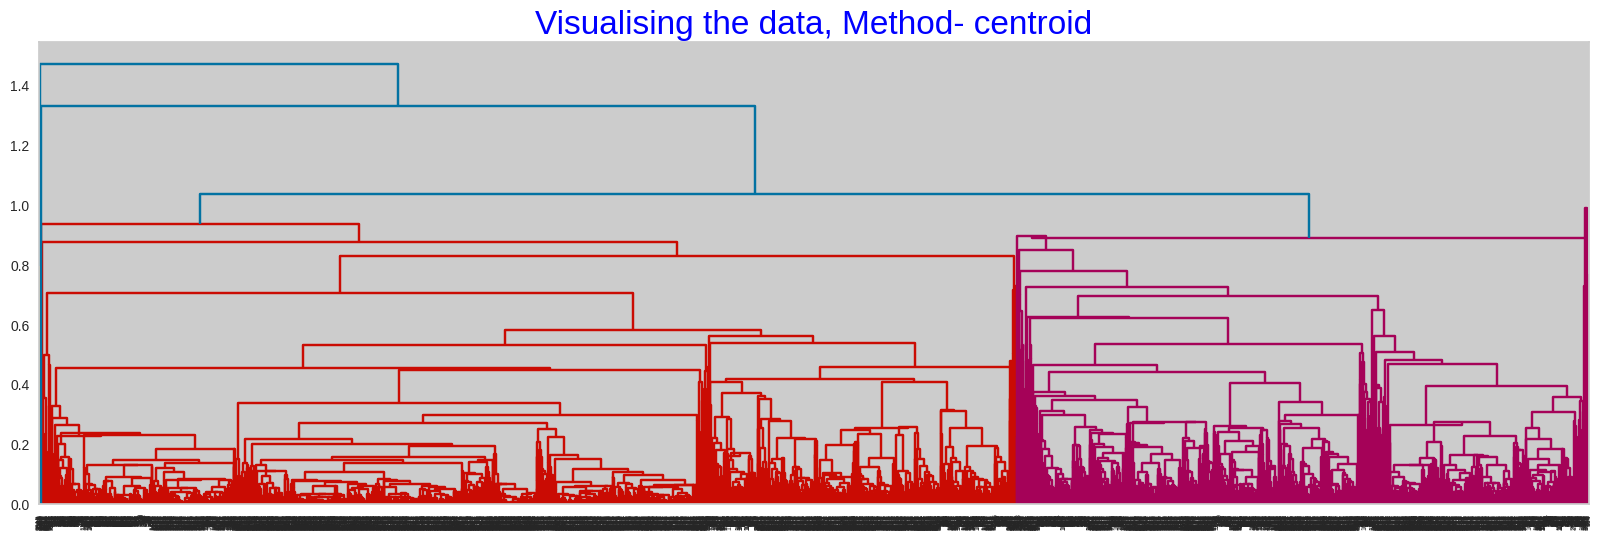

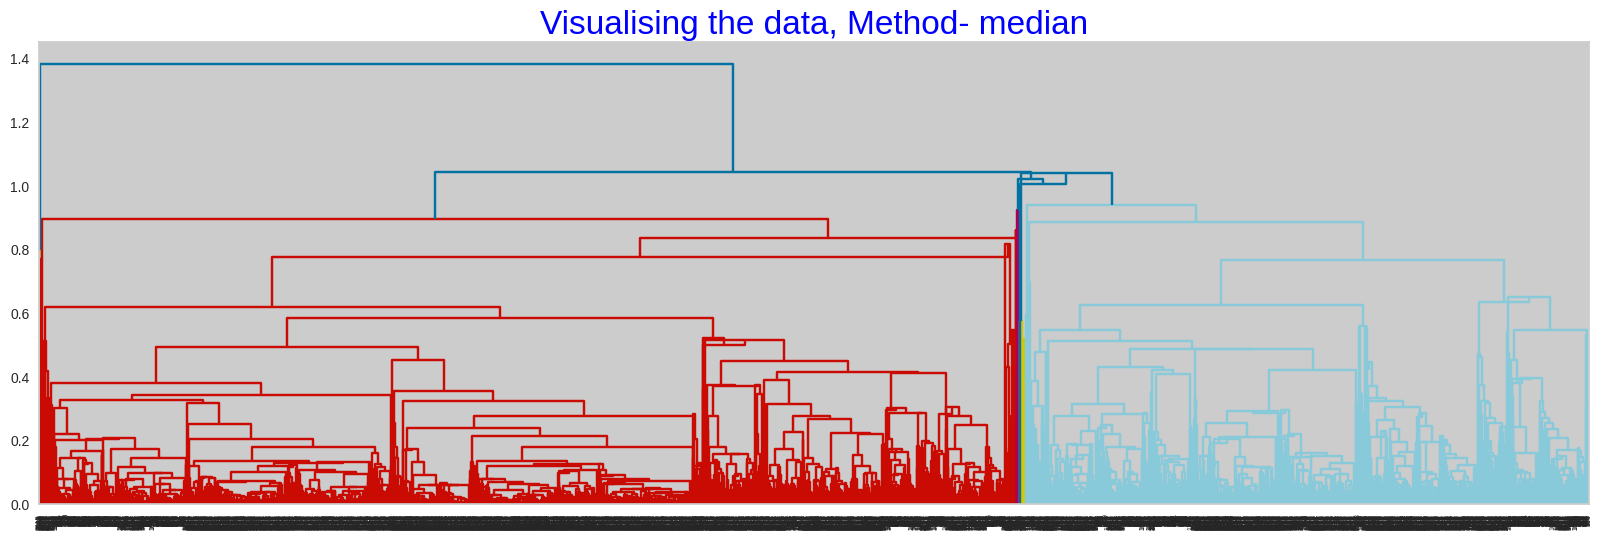

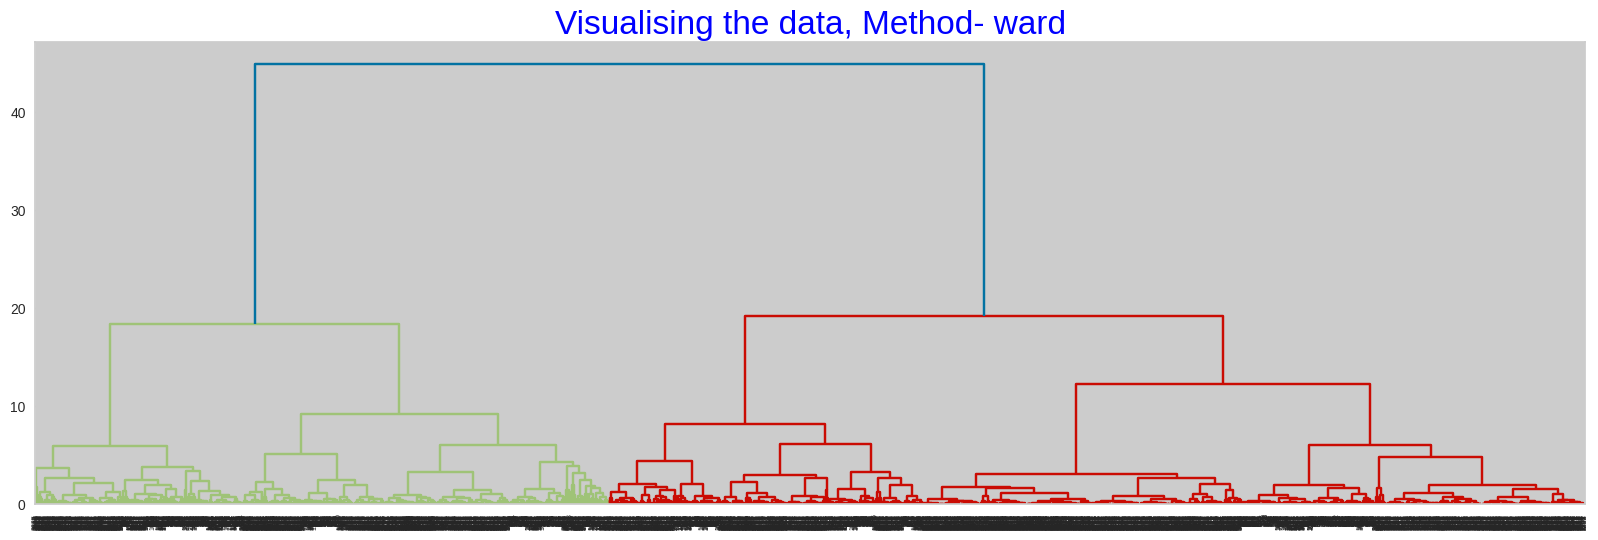

In [63]:
# Applying Dendrogram on data. Or you may apply it on Standardized/normalized indepedent variable data.
# Here diffrent linkage method from hyperparameter is used to see diff between methods for understanding.
# Ward method is commanly used since it is simpler to visualize understanding.
# Find number of cluster's using color coding of dendrogram. Each color indicates one cluster.

for methods in ['single','complete','average','weighted','centroid','median','ward']:
    plt.figure(figsize =(20, 6))

    dict = {'fontsize':24,'fontweight' :16, 'color' : 'blue'}

    plt.title('Visualising the data, Method- {}'.format(methods),fontdict = dict)
    Dendrogram1 = sch.dendrogram(sch.linkage(minmax_df, method = methods,optimal_ordering=False))

In [64]:
n_clusters = [2,3,4,5,6,7,8]  # always start number from 2.

for n_clusters in n_clusters:
    for linkages in ["ward", "complete", "average", "single"]:
        hie_cluster1 = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkages) # bydefault it takes linkage 'ward'
        hie_labels1 = hie_cluster1.fit_predict(minmax_df)
        silhouette_score1 = sil(minmax_df, hie_labels1)
        print("For n_clusters =", n_clusters,"The average silhouette_score with linkage-",linkages, ':',silhouette_score1)
    print()

For n_clusters = 2 The average silhouette_score with linkage- ward : 0.535888544052936
For n_clusters = 2 The average silhouette_score with linkage- complete : 0.4703657329091562
For n_clusters = 2 The average silhouette_score with linkage- average : 0.4703657329091562
For n_clusters = 2 The average silhouette_score with linkage- single : 0.535888544052936

For n_clusters = 3 The average silhouette_score with linkage- ward : 0.4354523188194701
For n_clusters = 3 The average silhouette_score with linkage- complete : 0.5318364582439801
For n_clusters = 3 The average silhouette_score with linkage- average : 0.3961439228235289
For n_clusters = 3 The average silhouette_score with linkage- single : 0.5351186081149816

For n_clusters = 4 The average silhouette_score with linkage- ward : 0.42489181550394106
For n_clusters = 4 The average silhouette_score with linkage- complete : 0.4645451427805366
For n_clusters = 4 The average silhouette_score with linkage- average : 0.5285595526639542
For n_

#### The seperation in Ward Method indicate that 2 is the optimal number for clusters.

<b>Ward</b> method is actually a method that tries to minimize the variance within each cluster. In K-means when we were trying to minimize the wcss to plot our elbow method chart, here it’s almost the same the only difference is that instead of minimizing wcss we are minimizing the within-cluster variants. That is the variance within each cluster.

### 7.2 Dendrogram on Standard Scaler Applied on Data<a class="anchor" id="7.2"></a>

In [65]:
n_clusters = [2,3,4,5,6,7,8,9,10]  # always start number from 2.

for n_clusters in n_clusters:
    for linkages in ["ward", "complete", "average", "single"]:
        hie_cluster1 = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkages) # bydefault it takes linkage 'ward'
        hie_labels1 = hie_cluster1.fit_predict(std_df)
        silhouette_score1 = sil(std_df, hie_labels1)
        print("For n_clusters =", n_clusters,"The average silhouette_score with linkage-",linkages, ':',silhouette_score1)
    print()

For n_clusters = 2 The average silhouette_score with linkage- ward : 0.2891560488062143
For n_clusters = 2 The average silhouette_score with linkage- complete : 0.8110876003700274
For n_clusters = 2 The average silhouette_score with linkage- average : 0.8110876003700274
For n_clusters = 2 The average silhouette_score with linkage- single : 0.8562622335599249

For n_clusters = 3 The average silhouette_score with linkage- ward : 0.2939395016802131
For n_clusters = 3 The average silhouette_score with linkage- complete : 0.7760498283333268
For n_clusters = 3 The average silhouette_score with linkage- average : 0.7838424148089893
For n_clusters = 3 The average silhouette_score with linkage- single : 0.7350131896585496

For n_clusters = 4 The average silhouette_score with linkage- ward : 0.308036175465823
For n_clusters = 4 The average silhouette_score with linkage- complete : 0.5985292155693238
For n_clusters = 4 The average silhouette_score with linkage- average : 0.7730785441296635
For n_

<b>Conclusion</b>: Max score is with cluster numbers 2 in standard scaler transformation and in Min Max scaler transformation.

+ Heirarchical clustering means creating a tree of clusters by iteratively grouping or separating data points. There are two types of hierarchical clustering: Agglomerative clustering Divisive clustering We now apply the Agglomerative clustering technique:Agglomerative clustering is kind of a bottom-up approach. Each data point is assumed to be a separate cluster at first. Then the similar clusters are iteratively combined

# 7.3 PCA

# 7.3 A) Running PCA of Standardized data.

In [66]:
# applying PCA on std_df

# we are considering 95% variance in n_components to not loose any data.

from sklearn.decomposition import PCA
pca_std = PCA(random_state=10, n_components=0.95)
pca_std_df= pca_std.fit_transform(std_df)

In [67]:
# eigenvalues..

print(pca_std.singular_values_)

[114.59929366  83.12095737  64.93711956  63.52257567  61.95910679
  60.39325992  56.7960262   49.8137685   37.95289819]


In [68]:
# variance containing in each formed PCA

print(pca_std.explained_variance_ratio_*100)

[29.8626543  15.71034052  9.58849765  9.17530952  8.72920759  8.29356916
  7.33500521  5.64239286  3.27532512]


In [69]:
# Cummulative variance ratio..

# this will give an idea of, at how many no. of PCAs, the cummulative addition of
#........variance will give much information..

cum_variance = np.cumsum(pca_std.explained_variance_ratio_*100)
cum_variance

array([29.8626543 , 45.57299482, 55.16149247, 64.33680198, 73.06600957,
       81.35957873, 88.69458394, 94.3369768 , 97.61230192])

#### Conclusion:

By applying PCA on standardized data with 95% variance it gives 9 PCA components.

### 7.3B Silhouette Score method for PCA Standard Scaled Data <a class="anchor" id="7.3B"></a>

In [70]:
n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]  # always start number from 2.

for n_clusters in n_clusters:
    for linkages in ["ward", "complete", "average", "single"]:
        hie_cluster1 = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkages) # bydefault it takes linkage 'ward'
        hie_labels1 = hie_cluster1.fit_predict(pca_std_df)
        silhouette_score1 = sil(pca_std_df, hie_labels1)
        print("For n_clusters =", n_clusters,"The average silhouette_score with linkage-",linkages, ':',silhouette_score1)
    print()

For n_clusters = 2 The average silhouette_score with linkage- ward : 0.19961390517290717
For n_clusters = 2 The average silhouette_score with linkage- complete : 0.8108617312271154
For n_clusters = 2 The average silhouette_score with linkage- average : 0.8108617312271154
For n_clusters = 2 The average silhouette_score with linkage- single : 0.738309454714575

For n_clusters = 3 The average silhouette_score with linkage- ward : 0.21104413292128169
For n_clusters = 3 The average silhouette_score with linkage- complete : 0.7783994853820995
For n_clusters = 3 The average silhouette_score with linkage- average : 0.7857918595410374
For n_clusters = 3 The average silhouette_score with linkage- single : 0.7380319163788157

For n_clusters = 4 The average silhouette_score with linkage- ward : 0.21497866326071854
For n_clusters = 4 The average silhouette_score with linkage- complete : 0.6685293540610888
For n_clusters = 4 The average silhouette_score with linkage- average : 0.775442673464243
For 

### 7.3C Run Hierarchical Clustering.(Agglomerative Clustering) <a class="anchor" id="7.3C"></a>

In [71]:
from sklearn.cluster import AgglomerativeClustering

In [72]:
agg_clustering = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="ward")

In [73]:
y_pred_hie = agg_clustering.fit_predict(pca_std_df)
print(y_pred_hie.shape)
y_pred_hie

(3998,)


array([1, 1, 1, ..., 0, 1, 1])

In [74]:
# Cluster numbers

agg_clustering.n_clusters_

5

In [75]:
# Clustering Score

(sil(pca_std_df, agg_clustering.labels_)*100).round(3)

22.37

# Putting Cluster lables into original dataset And analysis of the same

In [76]:
# Concating Labels with main dataset copy

df['Hierarchical_labels'] = agg_clustering.labels_
df.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,Hierarchical_labels
0,1,28143,0,1,1,1,174,1,0,0,7000,0,1,1
1,2,19244,0,1,1,1,215,2,0,0,6968,0,1,1
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,1,1
3,4,14776,0,1,1,1,500,1,0,0,6952,0,1,1
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,0,0


In [77]:
df.groupby('Hierarchical_labels').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Hierarchical_labels,,,,,,,,,,,,,
0,1765.169591,99574.760234,242.013495,2.777328,1.000000,1.000000,26622.358075,14.954116,515.867296,1.592892,4582.250112,0.618084,0.372020
1,2352.603490,36158.555355,6.608905,1.093261,1.000602,1.000000,3043.408544,6.067990,119.411552,0.373045,3486.102286,0.021661,0.991576
2,1736.480769,145767.807692,483.692308,2.576923,1.000000,1.000000,41204.115385,35.596154,8882.211538,23.326923,4557.961538,0.865385,0.134615
3,2269.348837,68823.976744,23.255814,1.139535,2.325581,1.000000,14588.395349,17.325581,582.627907,2.209302,3968.953488,0.395349,0.604651
4,1742.444444,129951.388889,65.666667,3.388889,1.000000,3.722222,86259.888889,26.222222,422.222222,1.333333,4488.777778,0.500000,0.500000


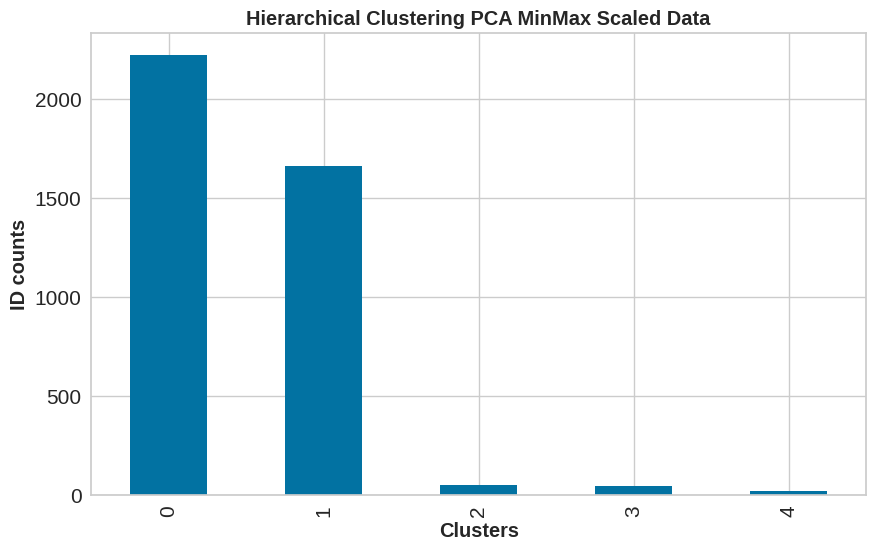

In [78]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['Hierarchical_labels']).count()['ID'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('Hierarchical Clustering PCA MinMax Scaled Data',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='large', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='large', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

# 7.3D Running PCA of MinMaxscalar data.

In [79]:
# applying PCA on minmax_df

from sklearn.decomposition import PCA

pca_minmax =  PCA(random_state=10, n_components=0.95)
pca_minmax_df = pca_minmax.fit_transform(minmax_df)

In [80]:
# eigenvalues..

print(pca_minmax.singular_values_)

[32.61283384 20.38274997 14.94964196  6.55127594]


In [81]:
# variance containing in each formed PCA

print(pca_minmax.explained_variance_ratio_*100)

[58.10519044 22.69673608 12.20954379  2.34471271]


#### Conclusion:

By applying PCA on MinMaxscalr transformation data gives 4 PCA components.

### 7.3E Silhouette Score method for PCA MinMax Scaled Data

In [82]:
n_clusters = [2,3,4,5,6,7,8]  # always start number from 2.

for n_clusters in n_clusters:
    for linkages in ["ward", "complete", "average", "single"]:
        hie_cluster2 = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkages) # bydefault it takes linkage 'ward'
        hie_labels2 = hie_cluster2.fit_predict(pca_minmax_df)
        silhouette_score2 = sil(pca_minmax_df, hie_labels2)
        print("For n_clusters =", n_clusters,"The average silhouette_score with linkage-",linkages, ':',silhouette_score2)
    print()

For n_clusters = 2 The average silhouette_score with linkage- ward : 0.5570203113320761
For n_clusters = 2 The average silhouette_score with linkage- complete : 0.45062835604506774
For n_clusters = 2 The average silhouette_score with linkage- average : 0.47467208868332433
For n_clusters = 2 The average silhouette_score with linkage- single : 0.5570203113320761

For n_clusters = 3 The average silhouette_score with linkage- ward : 0.4668018757689699
For n_clusters = 3 The average silhouette_score with linkage- complete : 0.5527079342536563
For n_clusters = 3 The average silhouette_score with linkage- average : 0.5545201621845232
For n_clusters = 3 The average silhouette_score with linkage- single : 0.5557695658754247

For n_clusters = 4 The average silhouette_score with linkage- ward : 0.46052119232965977
For n_clusters = 4 The average silhouette_score with linkage- complete : 0.509491332840777
For n_clusters = 4 The average silhouette_score with linkage- average : 0.4979294044354528
For

<b>Conclusion</b>: Max score is with cluster numbers 2 for ward and mostly others.

# 7.3F Run Hierarchical Clustering.(Agglomerative Clustering)

In [83]:
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
y_pred_hie = agg_clustering.fit_predict(pca_minmax_df)
print(y_pred_hie.shape)
y_pred_hie

(3998,)


array([0, 0, 0, ..., 1, 0, 0])

In [84]:
# Cluster numbers

agg_clustering.n_clusters_

2

In [85]:
# Clustering Score

(sil(pca_minmax_df, agg_clustering.labels_)*100).round(3)

55.702

### Putting Cluster lables into original dataset And analysis of the same

In [86]:
# Concating Labels with main dataset copy

df['Hierarchical_labels'] = agg_clustering.labels_
df.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,Hierarchical_labels
0,1,28143,0,1,1,1,174,1,0,0,7000,0,1,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0,1,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,1,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0,1,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,0,1


In [87]:
df.groupby('Hierarchical_labels').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Hierarchical_labels,,,,,,,,,,,,,
0,2172.447358,59960.528407,89.208184,1.713548,1.013905,1.008741,10387.715932,9.197855,227.986492,0.656337,3821.676599,0.009535,1.0
1,1745.571911,96831.899392,237.526671,2.648211,1.015530,1.018231,28640.350439,15.695476,854.774477,2.593518,4624.956786,0.983795,0.0


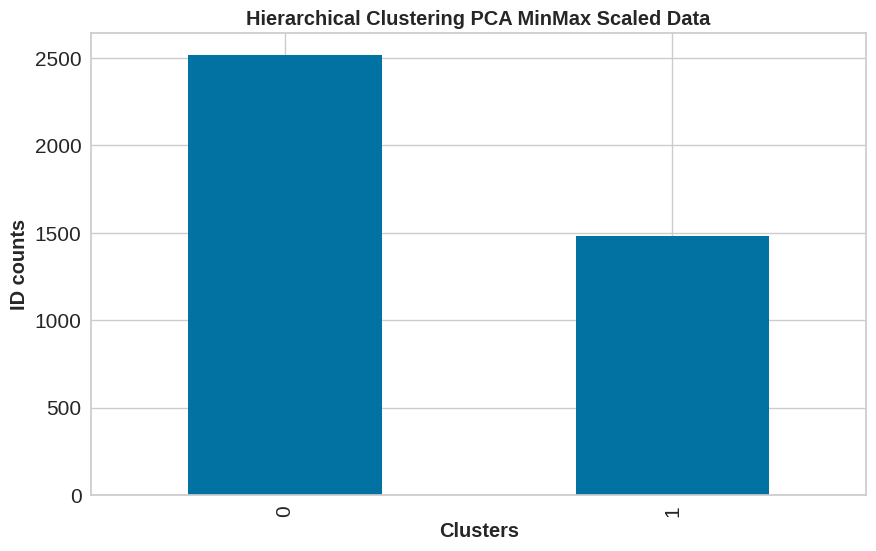

In [88]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['Hierarchical_labels']).count()['ID'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('Hierarchical Clustering PCA MinMax Scaled Data',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='large', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='large', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

## 8. DBSCAN - (Density Based Spatial Clustering of Applications with Noise)

Why do we need a Density-Based clustering algorithm like DBSCAN when we already have K-means clustering?

K-Means clustering may cluster loosely related observations together. Every observation becomes a part of some cluster eventually, even if the observations are scattered far away in the vector space. Since clusters depend on the mean value of cluster elements, each data point plays a role in forming the clusters. A slight change in data points might affect the clustering outcome. This problem is greatly reduced in DBSCAN due to the way clusters are formed. This is usually not a big problem unless we come across some odd shape data.

Another challenge with k-means is that you need to specify the number of clusters (“k”) in order to use it. Much of the time, we won’t know what a reasonable k value is a priori.

What’s nice about DBSCAN is that you don’t have to specify the number of clusters to use it. All you need is a function to calculate the distance between values and some guidance for what amount of distance is considered “close”. DBSCAN also produces more reasonable results than k-means across a variety of different distributions. Below figure illustrates the fact:

![FilterMethod](https://miro.medium.com/max/1339/0*xu3GYMsWu9QiKNOo.png)

 Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is a base algorithm for density-based clustering. It can discover clusters of different shapes and sizes from a large amount of data, which is containing noise and outliers.

<b>The DBSCAN algorithm uses two parameters</b>:

+ minPts: The minimum number of points (a threshold) clustered together for a region to be considered dense.

+ eps (ε): A distance measure that will be used to locate the points in the neighborhood of any point.

<b>These parameters can be understood if we explore two concepts called Density Reachability and Density Connectivity.</b>

+ Reachability in terms of density establishes a point to be reachable from another if it lies within a particular distance (eps) from it.

+ Connectivity, on the other hand, involves a transitivity based chaining-approach to determine whether points are located in a particular cluster. For example, p and q points could be connected if p->r->s->t->q, where a->b means b is in the neighborhood of a.

<b>There are three types of points after the DBSCAN clustering is complete:

![FilterMethod](https://miro.medium.com/max/627/1*yT96veo7Zb5QeswV7Vr7YQ.png)

##### Core — This is a point that has at least m points within distance n from itself.
##### Border — This is a point that has at least one Core point at a distance n.
##### Noise — This is a point that is neither a Core nor a Border. And it has less than m points within distance n from its

#### Minimum Samples (“MinPts”)
There is no automatic way to determine the MinPts value for DBSCAN. Ultimately, the MinPts value should be set using domain knowledge and familiarity with the data set. From some research I’ve done, here are a few rules of thumb for selecting the MinPts value:
+ The larger the data set, the larger the value of MinPts should be
+ If the data set is noisier, choose a larger value of MinPts
+ Generally, MinPts should be greater than or equal to the dimensionality of the data set
+ For 2-dimensional data, use DBSCAN’s default value of MinPts = 4 (Ester et al., 1996).
+ If your data has more than 2 dimensions, choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998).

#### Epsilon (ε)
After you select your MinPts value, you can move on to determining ε. One technique to automatically determine the optimal ε value is described in this <a href="https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf">paper</a>. This technique calculates the average distance between each point and its k nearest neighbors, where k = the MinPts value you selected. The average k-distances are then plotted in ascending order on a k-distance graph. You’ll find the optimal value for ε at the point of maximum curvature (i.e. where the graph has the greatest slope).

### 8.1 DBSCAN of Standard Scaled Data

##### To choose the best combination of the algorithm parameters I will first create a matrix of investigated combinations.

In [89]:
from itertools import product

eps_values = np.arange(0.25,3,0.25) # eps values to be investigated
min_samples = np.arange(3,23) # min_samples values to be investigated
DBSCAN_params = list(product(eps_values, min_samples))

In [90]:
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(std_df)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(std_df, DBS_clustering.labels_))

##### Collecting number of generated clusters.

A heatplot below shows how many clusters were genreated by the algorithm for the respective parameters combinations.


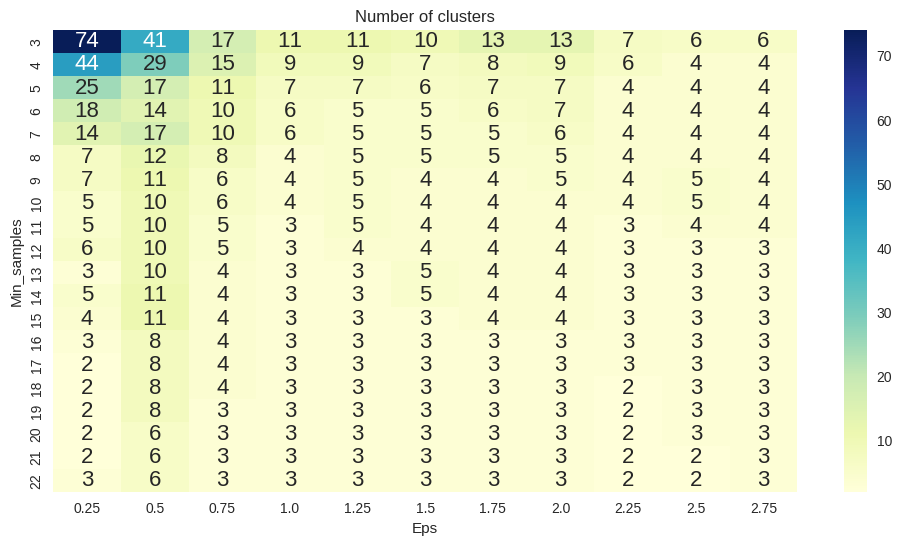

In [91]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
print('A heatplot below shows how many clusters were genreated by the algorithm for the respective parameters combinations.')
plt.show()

## As the heatplot above shows, the number of clusters vary from 74 to 2.

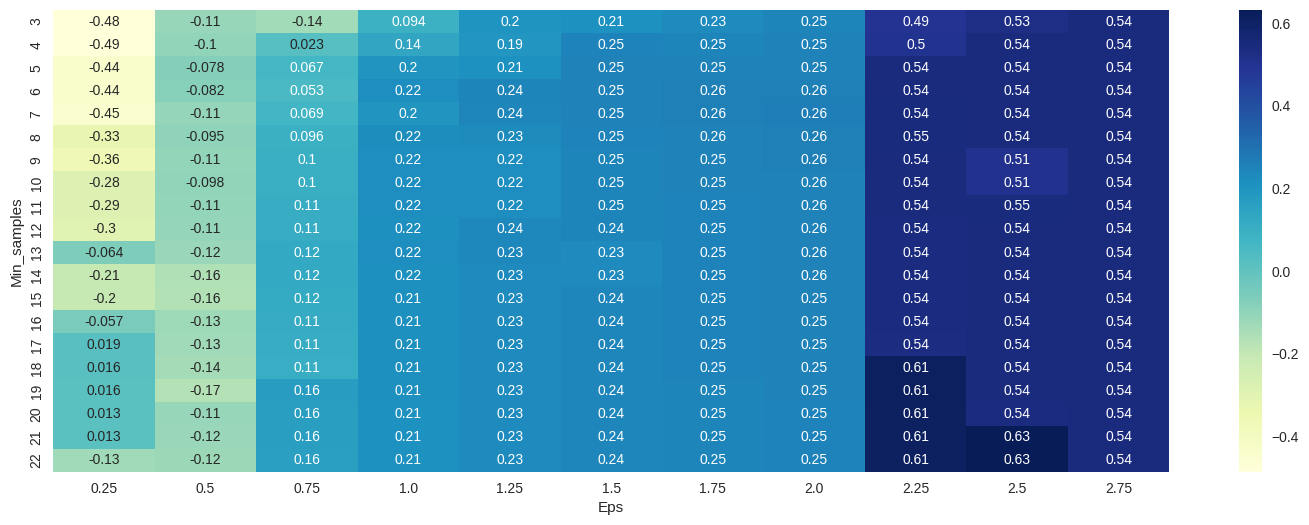

In [92]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

# Global maximum is 0.63 for eps = 2.5 and min_samples = 21 and 22

In [93]:
epsilon =  [0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75]
min_samples = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]


sil_avg = []
max_value = [0,0,0,0]

for i in range(len(epsilon)):
    for j in range(len(min_samples)):

        db = DBSCAN(min_samples = min_samples[j], eps =epsilon[i]).fit(std_df)
        #cluster_labels=dbscan.fit_predict(data)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)


        silhouette_avg = sil(std_df, labels)
        if silhouette_avg > max_value[3]:
            max_value=(epsilon[i], min_samples[j], n_clusters_, silhouette_avg)
        sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0],
      "\nmin_sample=", max_value[1],
      "\nnumber of clusters=", max_value[2],
      "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 2.5 
min_sample= 21 
number of clusters= 1 
average silhouette score= 0.6319


### Run DBSCAN on Standard Scaled data with optimal min_sample and epsilon values

In [94]:
dbscan = DBSCAN(eps=2.5, min_samples=21)
dbscan.fit(std_df)

DBSCAN(eps=2.5, min_samples=21)

In [95]:
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [96]:
df['DBSCAN_labels'] = dbscan.labels_
df.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,Hierarchical_labels,DBSCAN_labels
0,1,28143,0,1,1,1,174,1,0,0,7000,0,1,0,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0,1,0,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,1,0,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0,1,0,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,0,1,0


In [97]:
df.groupby('DBSCAN_labels').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,Hierarchical_labels
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
DBSCAN_labels,,,,,,,,,,,,,,
-1,1708.918269,209846.822115,1497.447115,2.471154,1.274038,1.235577,43964.149038,24.350962,3169.754808,9.413462,4768.629808,0.677885,0.312500,0.687500
0,2031.078364,66142.626385,69.879947,2.037203,1.000264,1.000000,15677.492612,10.905277,311.465435,0.932718,4083.600528,0.353562,0.646966,0.353034


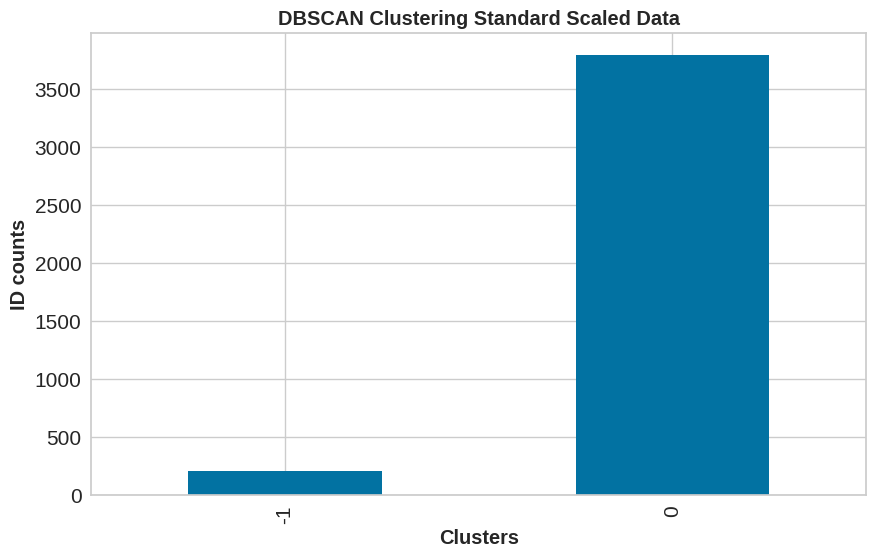

In [98]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['DBSCAN_labels']).count()['ID'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('DBSCAN Clustering Standard Scaled Data',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='large', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='large', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

# 8.2 DBSCAN on MinMax Scaled Data

## To choose the best combination of the algorithm parameters I will first create a matrix of investigated combinations.

In [99]:
from itertools import product

eps_values = np.arange(0.25,1.25,0.25) # eps values to be investigated
min_samples = np.arange(3,23) # min_samples values to be investigated
DBSCAN_params = list(product(eps_values, min_samples))

In [100]:
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(minmax_df)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(minmax_df, DBS_clustering.labels_))

# Collecting number of generated clusters.

A heatplot below shows how many clusters were genreated by the algorithm for the respective parameters combinations.


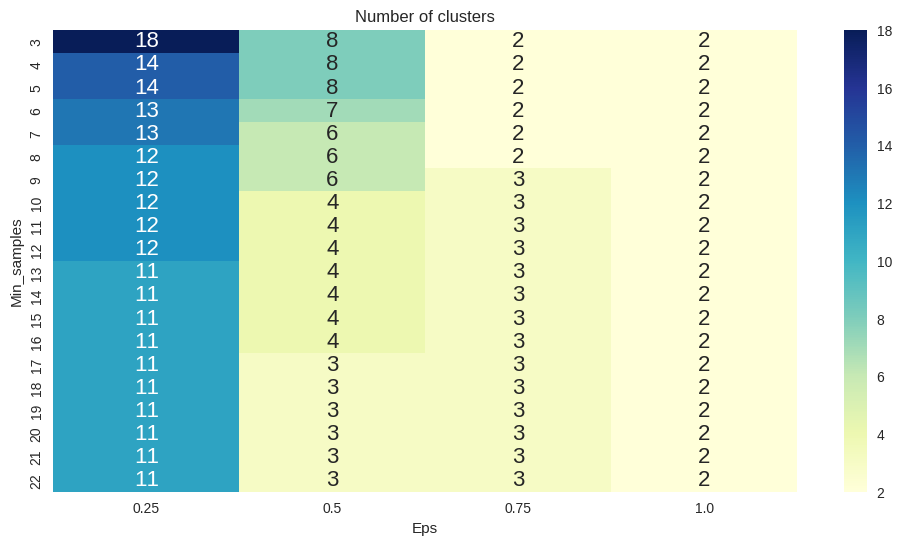

In [101]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
print('A heatplot below shows how many clusters were genreated by the algorithm for the respective parameters combinations.')
plt.show()

# As the heatplot above shows, the number of clusters vary from 18 to 2.

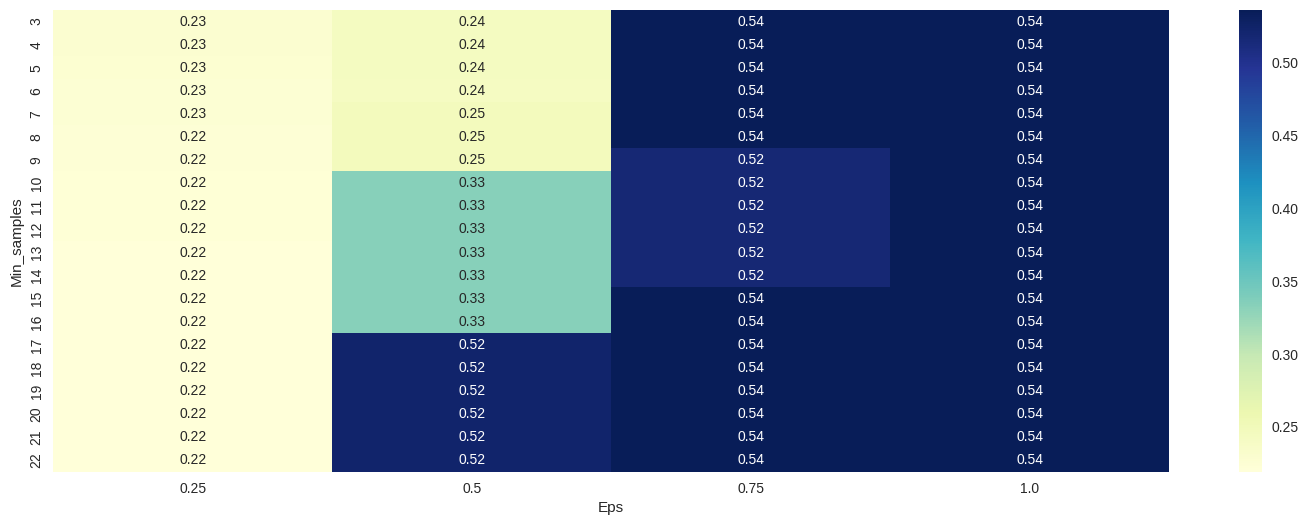

In [102]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

## Global maximum is 0.54 for eps=1.0 and min_samples=from 22 to 3

In [103]:
epsilon = [0.25,0.5,0.75,1]
min_samples = [11,12,13,14,15,16,17,18,19,20,21,22]


sil_avg = []
max_value = [0,0,0,0]

for i in range(len(epsilon)):
    for j in range(len(min_samples)):

        db = DBSCAN(min_samples = min_samples[j], eps =epsilon[i]).fit(minmax_df)
        #cluster_labels=dbscan.fit_predict(data)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)


        silhouette_avg = sil(minmax_df, labels)
        if silhouette_avg > max_value[3]:
            max_value=(epsilon[i], min_samples[j], n_clusters_, silhouette_avg)
        sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0],
      "\nmin_sample=", max_value[1],
      "\nnumber of clusters=", max_value[2],
      "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 1 
min_sample= 11 
number of clusters= 2 
average silhouette score= 0.5359


In [104]:
epsilon = [0.25,0.5,0.75,1]
min_samples = [3,4,5,6,7,8,9,10,11]


sil_avg = []
max_value = [0,0,0,0]

for i in range(len(epsilon)):
    for j in range(len(min_samples)):

        db = DBSCAN(min_samples = min_samples[j], eps =epsilon[i]).fit(minmax_df)
        #cluster_labels=dbscan.fit_predict(data)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)


        silhouette_avg = sil(minmax_df, labels)
        if silhouette_avg > max_value[3]:
            max_value=(epsilon[i], min_samples[j], n_clusters_, silhouette_avg)
        sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0],
      "\nmin_sample=", max_value[1],
      "\nnumber of clusters=", max_value[2],
      "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 0.75 
min_sample= 3 
number of clusters= 2 
average silhouette score= 0.5359


## Run DBSCAN on MinMax Scaled data with optimal min_sample and epsilon values

In [105]:
dbscan = DBSCAN(eps=1, min_samples=22) # min_samples = number of clumns * 3
dbscan.fit(minmax_df)

DBSCAN(eps=1, min_samples=22)

In [106]:
dbscan.labels_

array([0, 0, 0, ..., 1, 0, 0])

In [107]:
# -1 are the noise points in our dataset and the rest are the clusters

In [108]:
# Concating Labels with main dataset copy

df['DBSCAN_labels'] = dbscan.labels_
df.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,Hierarchical_labels,DBSCAN_labels
0,1,28143,0,1,1,1,174,1,0,0,7000,0,1,0,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0,1,0,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,1,0,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0,1,0,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,0,1,1


In [109]:
df.groupby('DBSCAN_labels').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,Hierarchical_labels
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
DBSCAN_labels,,,,,,,,,,,,,,
0,2172.447358,59960.528407,89.208184,1.713548,1.013905,1.008741,10387.715932,9.197855,227.986492,0.656337,3821.676599,0.009535,1.0,0.0
1,1745.571911,96831.899392,237.526671,2.648211,1.015530,1.018231,28640.350439,15.695476,854.774477,2.593518,4624.956786,0.983795,0.0,1.0


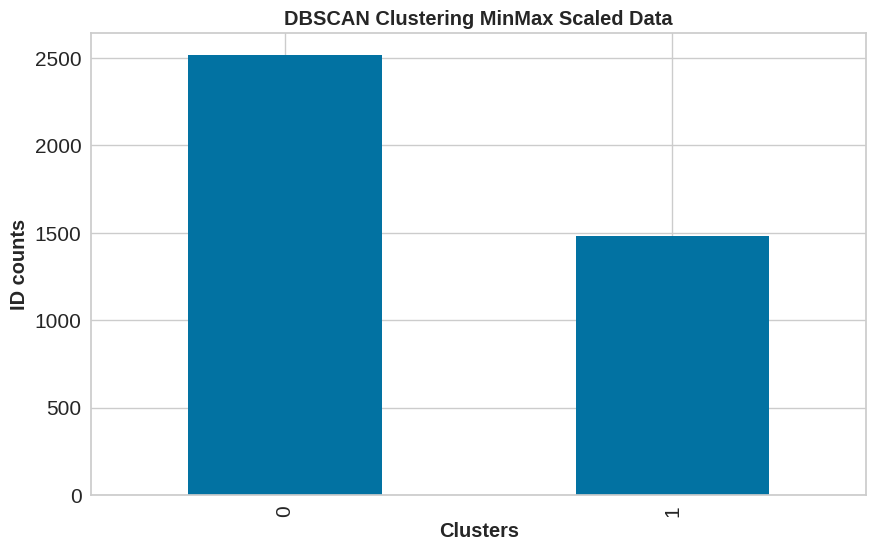

In [110]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['DBSCAN_labels']).count()['ID'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('DBSCAN Clustering MinMax Scaled Data',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='large', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='large', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

Conclusion:

In cluster number 0 & 1 there are more customers. Need to focus on cluster 0 & 1.

In [111]:
# Sorting elements based on cluster label assigned and taking average for insights.

cluster1 = pd.DataFrame(df.loc[df.DBSCAN_labels==0].mean(),columns= ['Cluster1_avg'])
cluster2 = pd.DataFrame(df.loc[df.DBSCAN_labels==1].mean(),columns= ['Cluster2_avg'])

In [112]:
avg_df = pd.concat([cluster1,cluster2],axis=1)
avg_df

,Cluster1_avg,Cluster2_avg
ID,2172.447358,1745.571911
Balance,59960.528407,96831.899392
Qual_miles,89.208184,237.526671
cc1_miles,1.713548,2.648211
cc2_miles,1.013905,1.015530
cc3_miles,1.008741,1.018231
Bonus_miles,10387.715932,28640.350439
Bonus_trans,9.197855,15.695476
Flight_miles_12mo,227.986492,854.774477
Flight_trans_12,0.656337,2.593518


Conclusion :

As decided need to focous on first two clusters..
Considering past Award status(0 or 1) cluster number2 shows award avg as 1 that means people awarded with scheme.
Similarly for cluster number 2 award avg. is 0. Since avg is low that means now maximim award given to cluster number1 in the past. Need to add future schemes for cluster number two members on different bonus points & different card transaction bonus.

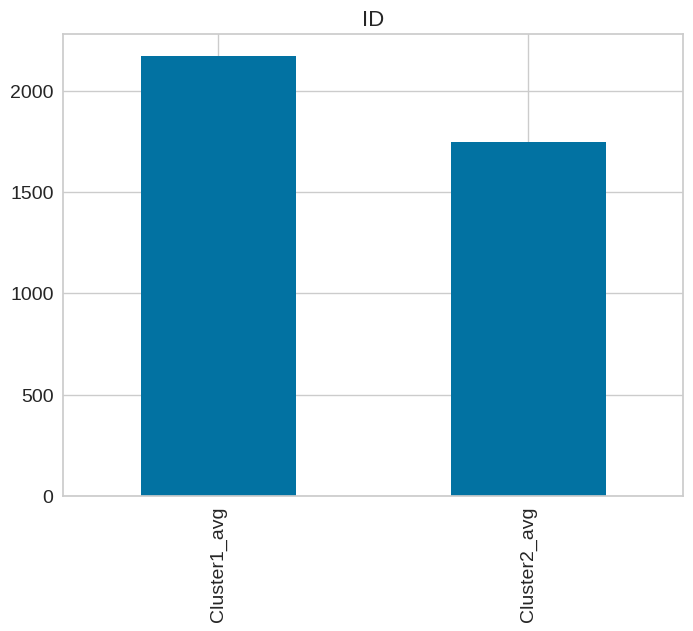

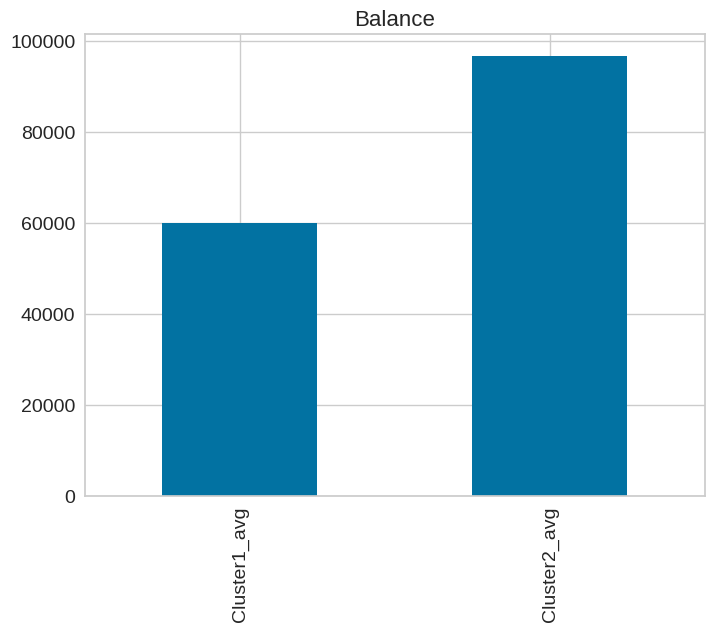

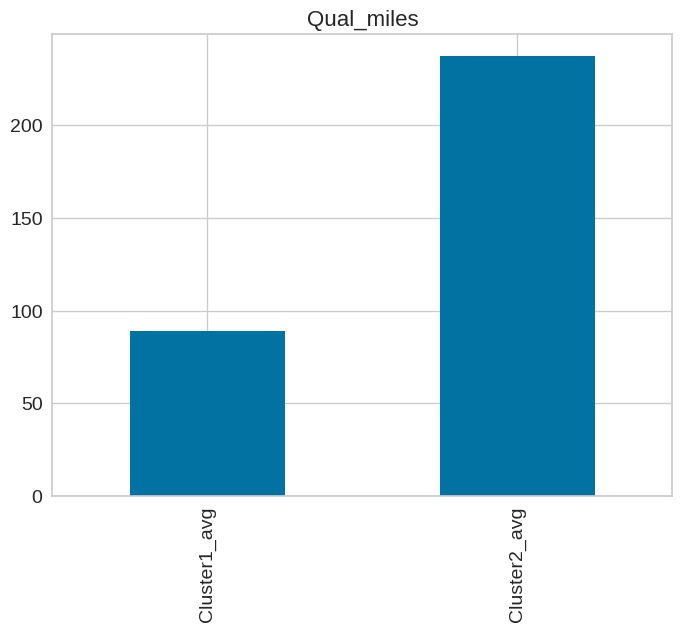

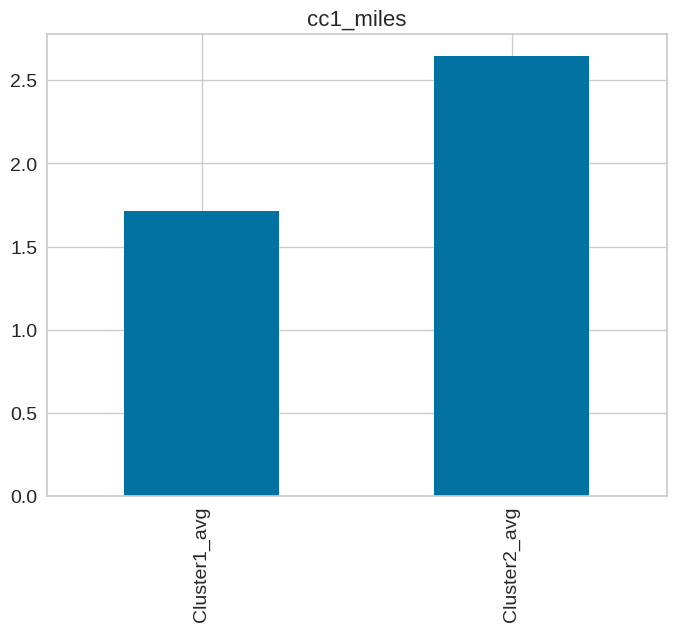

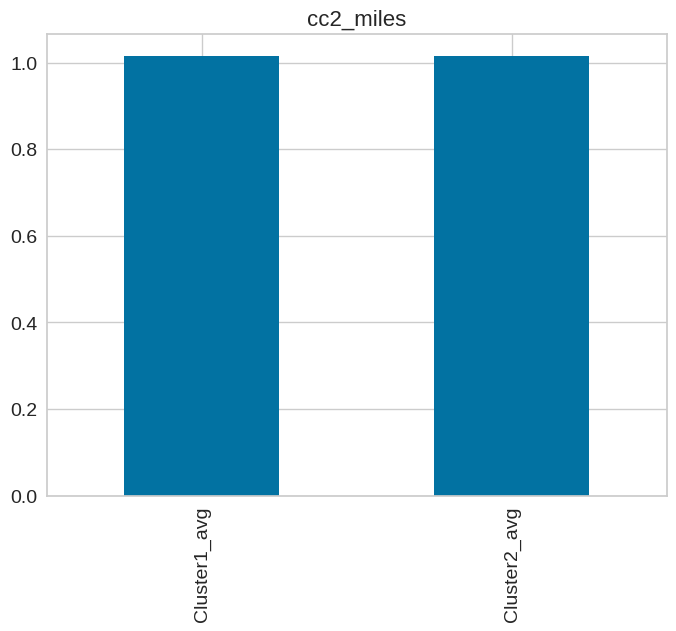

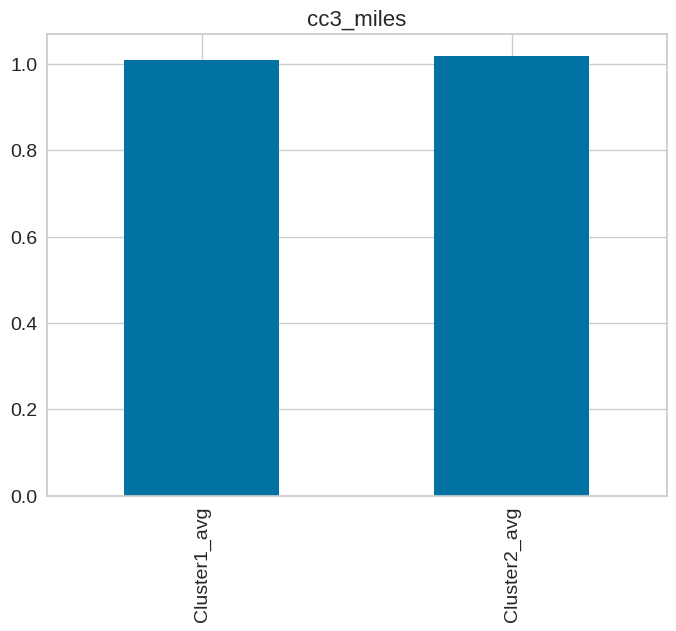

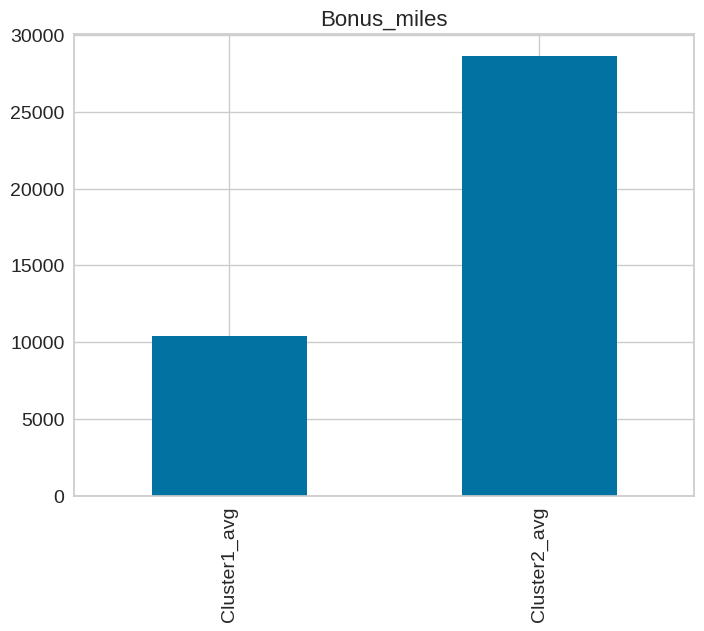

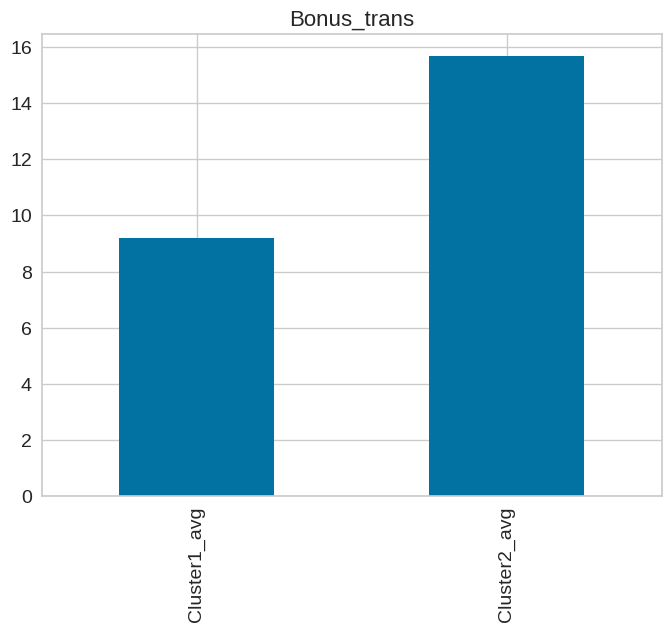

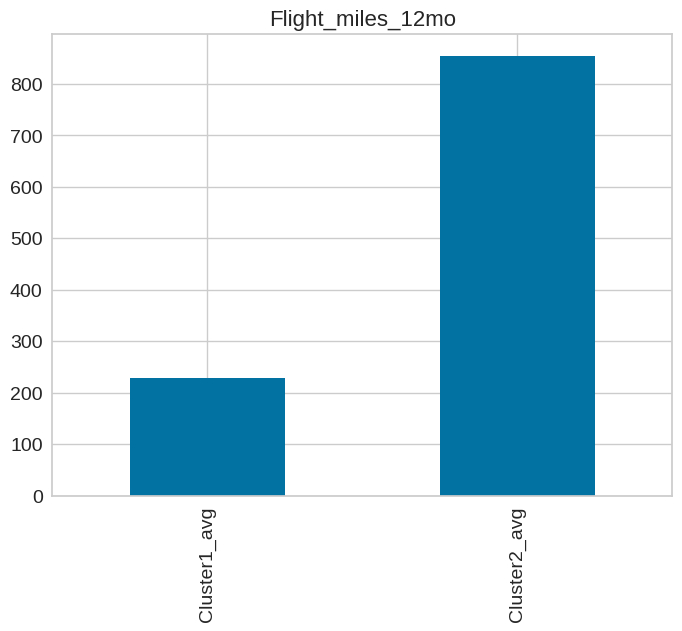

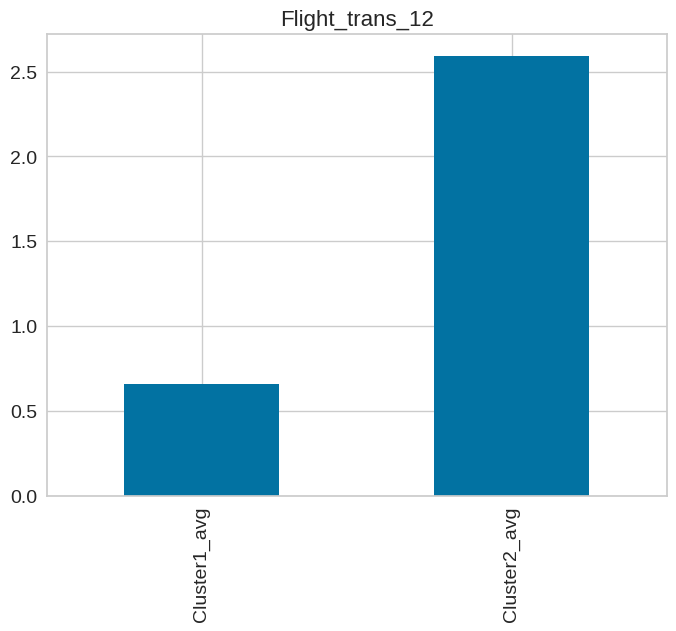

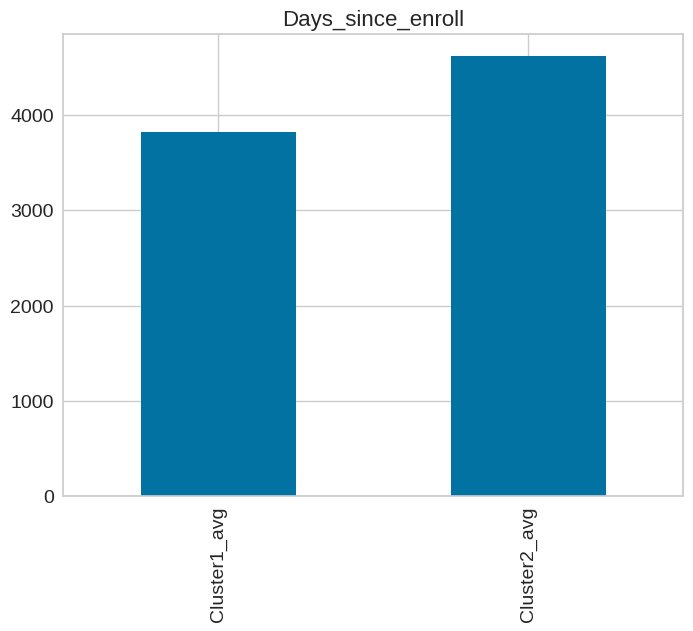

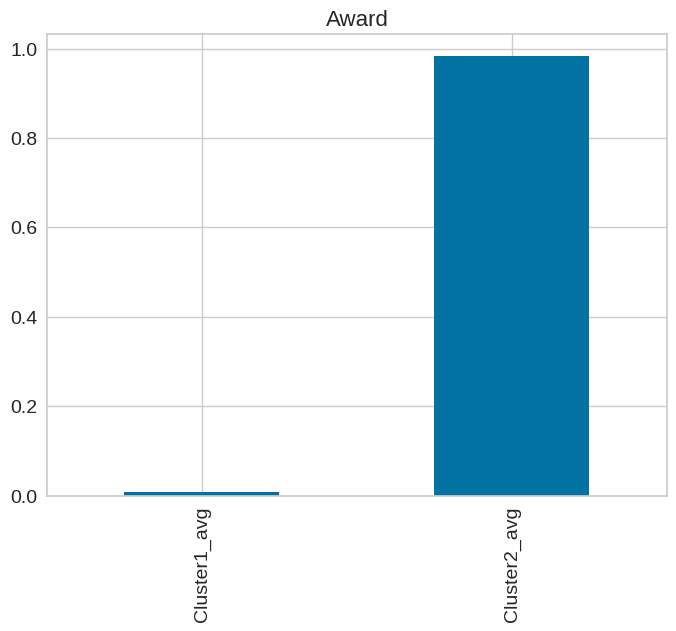

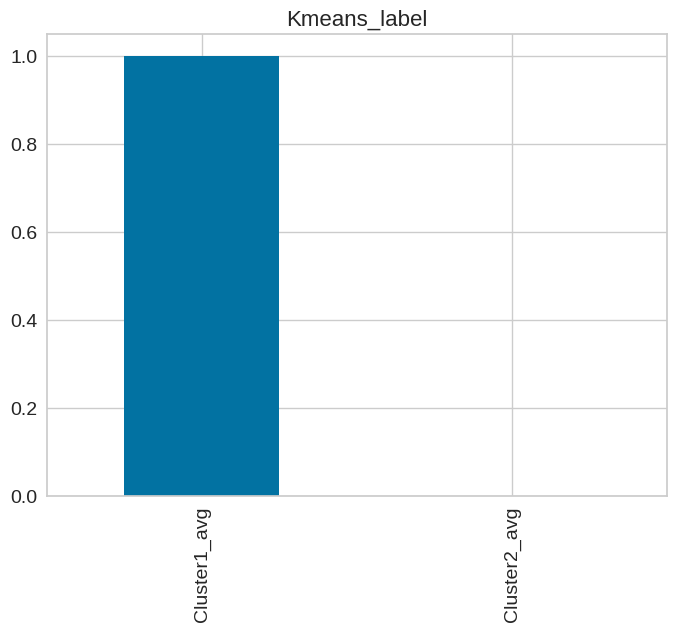

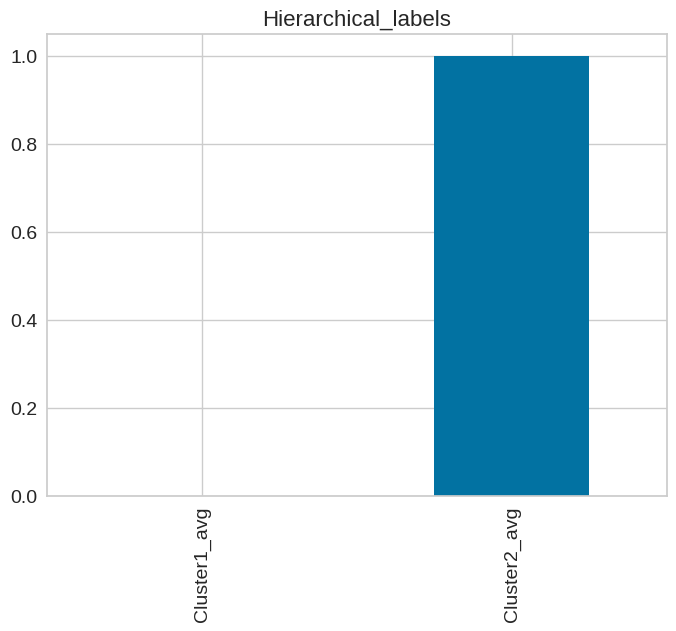

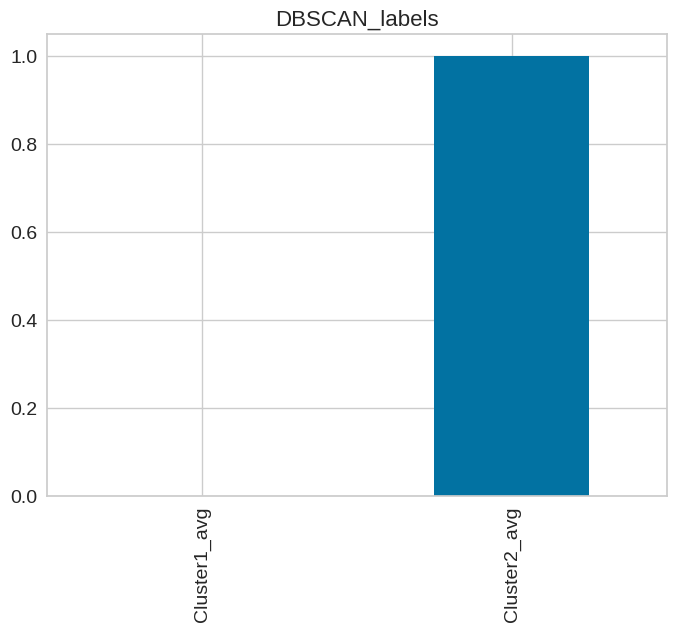

In [113]:
# Extract and plot one Column data .xs method
for i , row in avg_df.iterrows():
    fig = plt.subplots(figsize=(8,6))
    j = avg_df.xs(i ,axis = 0)
    plt.title(i, fontsize=16, fontweight=20)
    j.plot(kind='bar',fontsize=14)
    plt.show()
    print()

# 9. Conclusion:<a class="anchor" id="9"></a>

##### I have applied EDA to analyze dataset.Discovered correlation between diff variables and found colinearity.
##### Applied Standardazation & MinMaxScalar transformation on the data to use Principle componets analysis effectively.
##### I have used & analyzed two clustering techniques here..i) KMeans, ii) Hierarchical Clusterig & iii) DBSCAN.

##### By applying clustering on diff. PCA obtained with diff transformation data shows fluctuation in model score. So finally the Standard Scaler found less score so not used for further model building.

##### KMeans clustering is sensitive to outliers

![FilterMethod](https://miro.medium.com/proxy/1*tc8UF-h0nQqUfLC8-0uInQ.gif)